<a href="https://colab.research.google.com/github/codedmachine111/ML/blob/master/Deep%20Learning/MNIST_WGAN(Transformer%20Generator).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets -q
import opendatasets as od
od.download("https://www.kaggle.com/competitions/digit-recognizer/data")

Skipping, found downloaded files in "./digit-recognizer" (use force=True to force download)


In [ ]:
!cp -r /content/digit-recognizer/* /content

In [ ]:
import numpy as np
from numpy import random
from numpy import vstack
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from numpy import expand_dims

import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense, Reshape, Conv2DTranspose, LeakyReLU, Dropout)

from keras import backend
from keras.optimizers import Adam
from keras.optimizers import RMSprop

from keras.models import Sequential
from keras.models import load_model

from keras.initializers import RandomNormal
from keras.constraints import Constraint
from keras.utils import plot_model

In [ ]:
train_df = pd.read_csv('/content/train.csv')
train_df_7 = train_df[train_df['label']==7]
X = train_df_7.drop(['label'], axis=1).values
X = (X - 127.5) / 127.5 # scale from [0,255] to [-1,1]
print(X.shape)

(4401, 784)


In [ ]:
# reshape flattened data into tensors
n_x = 28     # size of image n_x by n_x
n_c = 1      # number of channels
X = X.reshape((-1, n_x, n_x, n_c))
print(X.shape)

(4401, 28, 28, 1)


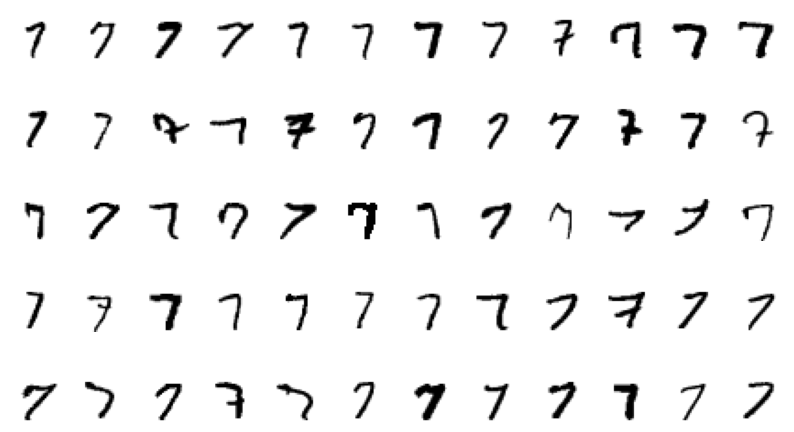

In [ ]:
# pick some random digits from the dataset X and look at them
plt.figure(figsize=(10,6))
n_digits = 60
select = random.randint(low=0,high=X.shape[0],size=n_digits)
for i, index in enumerate(select):
    plt.subplot(5, 12, i+1)
    plt.imshow(X[index].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()


The Critic

The critic takes a sample "digit" from our dataset and says how real or fake it is.

Inputs: "digit" 28x28 pixels in size; one channel.

Outputs: linear regression, degree the sample is real.


In [ ]:
class ClipConstraint(Constraint):
    """
    clip model weights to a given hypercube
    """
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    def get_config(self):
        return {'clip_value': self.clip_value}


In [ ]:
def wasserstein_loss(y_true, y_pred):
    """
    Wasserstein loss function
    """
    return backend.mean(y_true * y_pred)

In [ ]:
def define_critic(in_shape=(n_x,n_x,n_c)):
    """
    Define the conv net for the critic
    """
    init = RandomNormal(stddev=0.02)    # weight initialization
    const = ClipConstraint(0.01)    # weight constraint
    model = Sequential()
    model.add(Conv2D(64,kernel_size=4,strides=2,padding='same',kernel_initializer=init,kernel_constraint=const,input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64,kernel_size=4,strides=2,padding='same',kernel_initializer=init,kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1,activation='linear'))
    opt = RMSprop(learning_rate=0.00005)    # define optimizer
    model.compile(loss=wasserstein_loss,optimizer=opt)
    return model

In [ ]:
critic = define_critic()
critic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          65600     
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 64)          256       
 chNormalization)                                                


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 1)                 3137      
                                                                 
Total params: 70337 (274.75 KB)
Trainable params: 70081 (273.75 KB)
Non-trainable params: 256 (1.00 KB)
_________________________________________________________________


In [ ]:
def generate_real_samples(data, n_samples):
    """
    Pick 'n_samples' randomly from 'data'
    """
    idx = random.randint(low=0,high=data.shape[0],size=n_samples)
    X = data[idx]
    Y = -np.ones((n_samples,1))
    return X, Y

In [ ]:
def define_generator(latent_dim):
    """
    Define the conv net for the generator
    """
    init = RandomNormal(stddev=0.02)    # weight initialization
    n_nodes = 128*7*7
    model = Sequential()
    model.add(Dense(n_nodes,kernel_initializer=init,input_dim=latent_dim)) # foundation for 7*7 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same')) # up-sample to 14*14 image
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',kernel_initializer=init)) # up-sample to 28*28 image
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1,kernel_size=7,activation='tanh',padding='same',kernel_initializer=init))
    return model

In [ ]:
gen = define_generator(100)
gen.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                        
                                                                 
 batch_normalization_2 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)      

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [ ]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
def Generator_MNIST(noise_dim,
                    projection_dim,
                    num_heads,
                    ff_dim):
    init = RandomNormal(stddev=0.02)
    # Input layer
    noise_input = layers.Input(shape=(100,))

    # Dense layer to map noise to an intermediate shape
    x = layers.Dense(14 * 14 * 64, kernel_initializer=init)(noise_input)
    x = layers.Reshape((14, 14, 64))(x)

    # Transformer blocks for capturing spatial dependencies in the noise
    x = TransformerBlock(64, num_heads, ff_dim)(x)
    x = TransformerBlock(64, num_heads, ff_dim)(x)

    # Upsampling block
    x = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = residual_block(x, downsample=False, filters=32)

    # converting to 1 channel
    x = layers.Conv2D(1, (7, 7), strides=(1, 1), padding='same', use_bias=False, activation='tanh', kernel_initializer=init)(x)

    return tf.keras.Model(inputs=noise_input, outputs=x)

In [ ]:
gen_projection_dim = 64
gen_num_heads = 4
gen_ff_dim = 4
noise_dim=100

In [ ]:
generator_m = Generator_MNIST(noise_dim, gen_projection_dim, gen_num_heads, gen_ff_dim)
generator_m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 12544)                1266944   ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 14, 14, 64)           0         ['dense_1[0][0]']             
                                                                                                  
 transformer_block (Transfo  (None, 14, 14, 64)           67204     ['reshape[0][0]']             
 rmerBlock)                                                                                   

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    """
    This generates points in the latent space as input for the generator
    """
    x_input = random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)     # reshape into a batch of inputs for the network
    return x_input

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    """
    Generate 'n_samples' of fake samples from the generator
    """
    X_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(X_input)    # generator predicts output
    Y = np.ones((n_samples,1))     # create class labels '1' for fake sample
    return X, Y

In [ ]:
def define_gan(g_model, c_model):
    """
    This takes as arguments the generator and critic and creates the GAN subsuming these two models.
    The weights in the critic are marked as not trainable,
    which only affects the weights as seen by the GAN and not the standalone discriminator model.
    """
    c_model.trainable = False     # make weights in the critic not trainable
    model = Sequential()
    model.add(g_model)
    model.add(c_model)
    opt = RMSprop(learning_rate=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [ ]:
gan = define_gan(generator_m, critic)
gan.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 28, 28, 1)         1454568   
                                                                 
 sequential (Sequential)     (None, 1)                 70337     
                                                                 
Total params: 1524905 (5.82 MB)
Trainable params: 1454376 (5.55 MB)
Non-trainable params: 70529 (275.50 KB)
_________________________________________________________________


In [ ]:
def save_plot(examples, step, n=10):
    """
    This creates and save a plot of generated images
    """
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap=plt.cm.binary)
    filename = '/content/drive/MyDrive/wgan_trans_res/generated_plot_e%04d.png' % (step+1)
    plt.savefig(filename)
    plt.close()

In [ ]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    """
    This plots generated images, save generator model
    """
    X_fake, Y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    X_fake = (X_fake+1)/2.0
    save_plot(X_fake, step)
    filename = '/content/drive/MyDrive/wgan_trans_res/generator_model_%04d.h5' % (step+1)
    g_model.save(filename)

In [ ]:
def train(g_model, c_model, gan_model, data, latent_dim, n_epochs=100, batch_size=64, n_critic=5):
    """
    This trains the combined generator and critic models in the GAN
    """
    batch_per_epoch = data.shape[0] // batch_size
    n_steps = batch_per_epoch * n_epochs
    half_batch = batch_size // 2
    for i in range(n_steps):
        for j in range(n_critic):
            X_real, Y_real = generate_real_samples(data, half_batch)   # randomly select real samples
            d_loss_real = c_model.train_on_batch(X_real, Y_real)
            X_fake, Y_fake = generate_fake_samples(g_model, latent_dim, half_batch)   # generate fake samples
            d_loss_fake = c_model.train_on_batch(X_fake, Y_fake)
        X_gan = generate_latent_points(latent_dim, batch_size)   # as input for generator
        Y_gan = -np.ones((batch_size, 1))
        g_loss = gan_model.train_on_batch(X_gan, Y_gan)   # update generator via the discriminator's error
        print('>%d, d_loss_real=%.3f, d_loss_fake=%.3f, g_loss=%.3f' % (i+1, d_loss_real, d_loss_fake, g_loss)) # summarize loss for batch
        # evaluate the model performance, after some epochs
        if (i+1) % batch_per_epoch == 0:
            summarize_performance(i, g_model, latent_dim)

In [ ]:
c_model = define_critic()
gan_model = define_gan(generator_m, c_model)
data = X
latent_dim=100
train(generator_m, c_model, gan_model, data, latent_dim)

1/1 [==============================] - 0s 16ms/step
>1, d_loss_real=-3.841, d_loss_fake=-0.464, g_loss=0.004
1/1 [==============================] - 0s 17ms/step
>2, d_loss_real=-6.383, d_loss_fake=-0.733, g_loss=0.007
1/1 [==============================] - 0s 16ms/step
>3, d_loss_real=-8.967, d_loss_fake=-0.835, g_loss=0.011
1/1 [==============================] - 0s 22ms/step
>4, d_loss_real=-10.868, d_loss_fake=-1.027, g_loss=0.014
1/1 [==============================] - 0s 16ms/step
>5, d_loss_real=-12.966, d_loss_fake=-1.191, g_loss=0.018
1/1 [==============================] - 0s 18ms/step
>6, d_loss_real=-14.605, d_loss_fake=-1.390, g_loss=0.026
1/1 [==============================] - 0s 19ms/step
>7, d_loss_real=-14.935, d_loss_fake=-1.752, g_loss=0.035
1/1 [==============================] - 0s 16ms/step
>8, d_loss_real=-16.744, d_loss_fake=-2.230, g_loss=0.041
1/1 [==============================] - 0s 19ms/step
>9, d_loss_real=-18.197, d_loss_fake=-2.629, g_loss=0.057
1/1 [========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 19ms/step
>69, d_loss_real=-49.096, d_loss_fake=-28.073, g_loss=3.115
1/1 [==============================] - 0s 17ms/step
>70, d_loss_real=-49.174, d_loss_fake=-28.005, g_loss=2.490
1/1 [==============================] - 0s 16ms/step
>71, d_loss_real=-50.580, d_loss_fake=-28.353, g_loss=2.619
1/1 [==============================] - 0s 18ms/step
>72, d_loss_real=-51.328, d_loss_fake=-29.776, g_loss=2.405
1/1 [==============================] - 0s 17ms/step
>73, d_loss_real=-49.848, d_loss_fake=-31.642, g_loss=1.557
1/1 [==============================] - 0s 19ms/step
>74, d_loss_real=-50.016, d_loss_fake=-32.670, g_loss=1.138
1/1 [==============================] - 0s 16ms/step
>75, d_loss_real=-50.369, d_loss_fake=-32.159, g_loss=0.509
1/1 [==============================] - 0s 17ms/step
>76, d_loss_real=-50.289, d_loss_fake=-33.728, g_loss=0.727
1/1 [==============================] - 0s 16ms/step
>77, d_loss_real=-52.509, d_loss_fake=-32.448, g_los

1/1 [==============================] - 0s 32ms/step
>137, d_loss_real=-88.724, d_loss_fake=-65.673, g_loss=-17.794
1/1 [==============================] - 0s 25ms/step
>138, d_loss_real=-90.101, d_loss_fake=-69.790, g_loss=-18.809
1/1 [==============================] - 0s 27ms/step
>139, d_loss_real=-92.241, d_loss_fake=-66.713, g_loss=-19.373
1/1 [==============================] - 0s 26ms/step
>140, d_loss_real=-92.087, d_loss_fake=-70.129, g_loss=-20.019
1/1 [==============================] - 0s 33ms/step
>141, d_loss_real=-90.212, d_loss_fake=-68.180, g_loss=-21.753
1/1 [==============================] - 0s 31ms/step
>142, d_loss_real=-93.184, d_loss_fake=-73.010, g_loss=-20.826
1/1 [==============================] - 0s 33ms/step
>143, d_loss_real=-89.165, d_loss_fake=-68.745, g_loss=-21.912
1/1 [==============================] - 0s 25ms/step
>144, d_loss_real=-90.706, d_loss_fake=-72.857, g_loss=-23.155
1/1 [==============================] - 0s 32ms/step
>145, d_loss_real=-92.683, d

1/1 [==============================] - 0s 19ms/step
>205, d_loss_real=-126.543, d_loss_fake=-83.392, g_loss=-37.826
1/1 [==============================] - 0s 19ms/step
>206, d_loss_real=-128.216, d_loss_fake=-92.337, g_loss=-37.559
1/1 [==============================] - 0s 19ms/step
>207, d_loss_real=-130.418, d_loss_fake=-86.428, g_loss=-37.514
1/1 [==============================] - 0s 18ms/step
>208, d_loss_real=-128.406, d_loss_fake=-88.108, g_loss=-37.327
1/1 [==============================] - 0s 22ms/step
>209, d_loss_real=-125.374, d_loss_fake=-90.621, g_loss=-38.279
1/1 [==============================] - 0s 16ms/step
>210, d_loss_real=-132.922, d_loss_fake=-99.512, g_loss=-37.071
1/1 [==============================] - 0s 18ms/step
>211, d_loss_real=-128.761, d_loss_fake=-92.407, g_loss=-37.043
1/1 [==============================] - 0s 18ms/step
>212, d_loss_real=-127.162, d_loss_fake=-95.801, g_loss=-39.666
1/1 [==============================] - 0s 19ms/step
>213, d_loss_real=-1

1/1 [==============================] - 0s 18ms/step
>273, d_loss_real=-163.149, d_loss_fake=-135.252, g_loss=-55.506
1/1 [==============================] - 0s 21ms/step
>274, d_loss_real=-167.393, d_loss_fake=-145.781, g_loss=-55.271
1/1 [==============================] - 0s 19ms/step
>275, d_loss_real=-167.938, d_loss_fake=-148.921, g_loss=-56.653
1/1 [==============================] - 0s 18ms/step
>276, d_loss_real=-170.014, d_loss_fake=-148.829, g_loss=-56.654
1/1 [==============================] - 0s 17ms/step
>277, d_loss_real=-173.223, d_loss_fake=-143.320, g_loss=-57.202
1/1 [==============================] - 0s 16ms/step
>278, d_loss_real=-176.058, d_loss_fake=-148.132, g_loss=-58.626
1/1 [==============================] - 0s 21ms/step
>279, d_loss_real=-171.652, d_loss_fake=-140.169, g_loss=-57.623
1/1 [==============================] - 0s 16ms/step
>280, d_loss_real=-170.372, d_loss_fake=-158.610, g_loss=-60.705
1/1 [==============================] - 0s 27ms/step
>281, d_loss

1/1 [==============================] - 0s 28ms/step
>341, d_loss_real=-219.933, d_loss_fake=-211.151, g_loss=-82.557
1/1 [==============================] - 0s 27ms/step
>342, d_loss_real=-222.512, d_loss_fake=-209.663, g_loss=-89.464
1/1 [==============================] - 0s 33ms/step
>343, d_loss_real=-221.685, d_loss_fake=-220.049, g_loss=-87.801
1/1 [==============================] - 0s 28ms/step
>344, d_loss_real=-219.996, d_loss_fake=-205.816, g_loss=-83.327
1/1 [==============================] - 0s 36ms/step
>345, d_loss_real=-221.487, d_loss_fake=-219.438, g_loss=-81.228
1/1 [==============================] - 0s 25ms/step
>346, d_loss_real=-217.149, d_loss_fake=-206.398, g_loss=-84.877
1/1 [==============================] - 0s 32ms/step
>347, d_loss_real=-217.413, d_loss_fake=-228.557, g_loss=-84.068
1/1 [==============================] - 0s 20ms/step
>348, d_loss_real=-218.054, d_loss_fake=-207.885, g_loss=-87.788
1/1 [==============================] - 0s 21ms/step
>349, d_loss

1/1 [==============================] - 0s 18ms/step
>409, d_loss_real=-173.351, d_loss_fake=-133.165, g_loss=-133.981
1/1 [==============================] - 0s 21ms/step
>410, d_loss_real=-174.505, d_loss_fake=-137.435, g_loss=-133.065
1/1 [==============================] - 0s 18ms/step
>411, d_loss_real=-175.398, d_loss_fake=-110.865, g_loss=-132.968
1/1 [==============================] - 0s 22ms/step
>412, d_loss_real=-118.784, d_loss_fake=-119.718, g_loss=-132.727
1/1 [==============================] - 0s 18ms/step
>413, d_loss_real=-196.592, d_loss_fake=-136.794, g_loss=-133.423
1/1 [==============================] - 0s 17ms/step
>414, d_loss_real=-168.880, d_loss_fake=-136.560, g_loss=-134.373
1/1 [==============================] - 0s 19ms/step
>415, d_loss_real=-181.114, d_loss_fake=-146.379, g_loss=-137.622
1/1 [==============================] - 0s 18ms/step
>416, d_loss_real=-197.034, d_loss_fake=-178.317, g_loss=-130.158
1/1 [==============================] - 0s 16ms/step
>417

1/1 [==============================] - 0s 23ms/step
>477, d_loss_real=-201.837, d_loss_fake=-167.130, g_loss=-162.592
1/1 [==============================] - 0s 19ms/step
>478, d_loss_real=-165.100, d_loss_fake=-112.811, g_loss=-155.961
1/1 [==============================] - 0s 16ms/step
>479, d_loss_real=-210.375, d_loss_fake=-169.609, g_loss=-180.339
1/1 [==============================] - 0s 18ms/step
>480, d_loss_real=-189.827, d_loss_fake=-205.388, g_loss=-175.648
1/1 [==============================] - 0s 16ms/step
>481, d_loss_real=-205.635, d_loss_fake=-207.088, g_loss=-168.440
1/1 [==============================] - 0s 20ms/step
>482, d_loss_real=-200.584, d_loss_fake=-149.360, g_loss=-166.527
1/1 [==============================] - 0s 17ms/step
>483, d_loss_real=-186.106, d_loss_fake=-182.842, g_loss=-172.300
1/1 [==============================] - 0s 18ms/step
>484, d_loss_real=-188.491, d_loss_fake=-222.131, g_loss=-173.642
1/1 [==============================] - 0s 20ms/step
>485

1/1 [==============================] - 0s 28ms/step
>545, d_loss_real=-277.698, d_loss_fake=-298.926, g_loss=-205.653
1/1 [==============================] - 0s 33ms/step
>546, d_loss_real=-295.594, d_loss_fake=-291.001, g_loss=-201.398
1/1 [==============================] - 0s 31ms/step
>547, d_loss_real=-276.725, d_loss_fake=-301.651, g_loss=-209.426
1/1 [==============================] - 0s 26ms/step
>548, d_loss_real=-295.956, d_loss_fake=-268.665, g_loss=-196.817
1/1 [==============================] - 0s 26ms/step
>549, d_loss_real=-294.656, d_loss_fake=-326.346, g_loss=-204.981
1/1 [==============================] - 0s 30ms/step
>550, d_loss_real=-300.974, d_loss_fake=-320.065, g_loss=-205.262
1/1 [==============================] - 0s 28ms/step
>551, d_loss_real=-314.899, d_loss_fake=-300.326, g_loss=-209.326
1/1 [==============================] - 0s 31ms/step
>552, d_loss_real=-294.340, d_loss_fake=-323.927, g_loss=-202.925
1/1 [==============================] - 0s 24ms/step
>553

1/1 [==============================] - 0s 18ms/step
>613, d_loss_real=-398.490, d_loss_fake=-435.767, g_loss=-221.800
1/1 [==============================] - 0s 18ms/step
>614, d_loss_real=-403.277, d_loss_fake=-424.938, g_loss=-221.583
1/1 [==============================] - 0s 25ms/step
>615, d_loss_real=-412.836, d_loss_fake=-442.797, g_loss=-218.485
1/1 [==============================] - 0s 27ms/step
>616, d_loss_real=-414.728, d_loss_fake=-439.255, g_loss=-225.348
1/1 [==============================] - 0s 26ms/step
>617, d_loss_real=-420.416, d_loss_fake=-449.278, g_loss=-224.844
1/1 [==============================] - 0s 39ms/step
>618, d_loss_real=-413.848, d_loss_fake=-439.288, g_loss=-218.877
1/1 [==============================] - 0s 16ms/step
>619, d_loss_real=-404.438, d_loss_fake=-445.413, g_loss=-222.612
1/1 [==============================] - 0s 16ms/step
>620, d_loss_real=-409.338, d_loss_fake=-439.499, g_loss=-219.336
1/1 [==============================] - 0s 16ms/step
>621

1/1 [==============================] - 0s 19ms/step
>681, d_loss_real=-508.090, d_loss_fake=-556.524, g_loss=-207.890
1/1 [==============================] - 0s 18ms/step
>682, d_loss_real=-509.263, d_loss_fake=-562.876, g_loss=-209.516
1/1 [==============================] - 0s 24ms/step
>683, d_loss_real=-506.176, d_loss_fake=-558.625, g_loss=-210.240
1/1 [==============================] - 0s 17ms/step
>684, d_loss_real=-508.185, d_loss_fake=-566.976, g_loss=-214.533
1/1 [==============================] - 0s 20ms/step
>685, d_loss_real=-506.925, d_loss_fake=-559.733, g_loss=-204.552
1/1 [==============================] - 0s 19ms/step
>686, d_loss_real=-515.235, d_loss_fake=-566.007, g_loss=-216.063
1/1 [==============================] - 0s 18ms/step
>687, d_loss_real=-511.379, d_loss_fake=-568.252, g_loss=-202.572
1/1 [==============================] - 0s 21ms/step
>688, d_loss_real=-522.357, d_loss_fake=-567.656, g_loss=-205.893
1/1 [==============================] - 0s 19ms/step
>689

1/1 [==============================] - 0s 24ms/step
>749, d_loss_real=-592.609, d_loss_fake=-655.740, g_loss=-227.201
1/1 [==============================] - 0s 25ms/step
>750, d_loss_real=-595.216, d_loss_fake=-653.944, g_loss=-220.660
1/1 [==============================] - 0s 25ms/step
>751, d_loss_real=-587.735, d_loss_fake=-660.274, g_loss=-213.132
1/1 [==============================] - 0s 23ms/step
>752, d_loss_real=-593.962, d_loss_fake=-662.356, g_loss=-223.052
1/1 [==============================] - 0s 25ms/step
>753, d_loss_real=-595.934, d_loss_fake=-656.467, g_loss=-227.206
1/1 [==============================] - 0s 25ms/step
>754, d_loss_real=-598.176, d_loss_fake=-661.106, g_loss=-226.571
1/1 [==============================] - 0s 31ms/step
>755, d_loss_real=-598.312, d_loss_fake=-663.888, g_loss=-220.600
1/1 [==============================] - 0s 27ms/step
>756, d_loss_real=-596.368, d_loss_fake=-662.411, g_loss=-227.081
1/1 [==============================] - 0s 24ms/step
>757

1/1 [==============================] - 0s 21ms/step
>817, d_loss_real=-661.791, d_loss_fake=-738.834, g_loss=-264.747
1/1 [==============================] - 0s 23ms/step
>818, d_loss_real=-672.203, d_loss_fake=-751.222, g_loss=-267.420
1/1 [==============================] - 0s 18ms/step
>819, d_loss_real=-672.778, d_loss_fake=-738.080, g_loss=-270.403
1/1 [==============================] - 0s 18ms/step
>820, d_loss_real=-672.122, d_loss_fake=-738.979, g_loss=-274.209
1/1 [==============================] - 0s 24ms/step
>821, d_loss_real=-678.345, d_loss_fake=-756.863, g_loss=-268.463
1/1 [==============================] - 0s 20ms/step
>822, d_loss_real=-677.997, d_loss_fake=-752.631, g_loss=-275.738
1/1 [==============================] - 0s 20ms/step
>823, d_loss_real=-676.716, d_loss_fake=-765.581, g_loss=-271.307
1/1 [==============================] - 0s 17ms/step
>824, d_loss_real=-677.055, d_loss_fake=-758.529, g_loss=-285.458
1/1 [==============================] - 0s 19ms/step
>825

1/1 [==============================] - 0s 30ms/step
>885, d_loss_real=-765.774, d_loss_fake=-841.113, g_loss=-314.185
1/1 [==============================] - 0s 17ms/step
>886, d_loss_real=-755.570, d_loss_fake=-845.535, g_loss=-311.613
1/1 [==============================] - 0s 17ms/step
>887, d_loss_real=-753.729, d_loss_fake=-851.151, g_loss=-330.152
1/1 [==============================] - 0s 19ms/step
>888, d_loss_real=-758.040, d_loss_fake=-850.880, g_loss=-323.645
1/1 [==============================] - 0s 22ms/step
>889, d_loss_real=-767.931, d_loss_fake=-850.511, g_loss=-322.832
1/1 [==============================] - 0s 17ms/step
>890, d_loss_real=-766.514, d_loss_fake=-859.679, g_loss=-310.853
1/1 [==============================] - 0s 21ms/step
>891, d_loss_real=-768.415, d_loss_fake=-849.867, g_loss=-308.087
1/1 [==============================] - 0s 19ms/step
>892, d_loss_real=-774.043, d_loss_fake=-863.539, g_loss=-330.878
1/1 [==============================] - 0s 16ms/step
>893

1/1 [==============================] - 0s 17ms/step
>953, d_loss_real=-851.047, d_loss_fake=-953.633, g_loss=-361.608
1/1 [==============================] - 0s 17ms/step
>954, d_loss_real=-840.591, d_loss_fake=-959.817, g_loss=-344.092
1/1 [==============================] - 0s 17ms/step
>955, d_loss_real=-838.544, d_loss_fake=-943.592, g_loss=-368.204
1/1 [==============================] - 0s 27ms/step
>956, d_loss_real=-857.539, d_loss_fake=-962.929, g_loss=-357.766
1/1 [==============================] - 0s 27ms/step
>957, d_loss_real=-854.754, d_loss_fake=-962.047, g_loss=-379.196
1/1 [==============================] - 0s 31ms/step
>958, d_loss_real=-860.854, d_loss_fake=-957.565, g_loss=-342.941
1/1 [==============================] - 0s 24ms/step
>959, d_loss_real=-868.013, d_loss_fake=-967.083, g_loss=-367.098
1/1 [==============================] - 0s 25ms/step
>960, d_loss_real=-866.177, d_loss_fake=-969.045, g_loss=-372.476
1/1 [==============================] - 0s 24ms/step
>961

1/1 [==============================] - 0s 25ms/step
>1021, d_loss_real=-950.310, d_loss_fake=-1059.260, g_loss=-425.782
1/1 [==============================] - 0s 27ms/step
>1022, d_loss_real=-945.113, d_loss_fake=-1041.914, g_loss=-433.065
1/1 [==============================] - 0s 22ms/step
>1023, d_loss_real=-952.781, d_loss_fake=-1058.000, g_loss=-404.747
1/1 [==============================] - 0s 20ms/step
>1024, d_loss_real=-956.960, d_loss_fake=-1060.214, g_loss=-432.913
1/1 [==============================] - 0s 22ms/step
>1025, d_loss_real=-951.703, d_loss_fake=-1054.441, g_loss=-425.235
1/1 [==============================] - 0s 24ms/step
>1026, d_loss_real=-953.113, d_loss_fake=-1055.825, g_loss=-429.891
1/1 [==============================] - 0s 21ms/step
>1027, d_loss_real=-957.959, d_loss_fake=-1071.955, g_loss=-421.169
1/1 [==============================] - 0s 21ms/step
>1028, d_loss_real=-954.682, d_loss_fake=-1056.530, g_loss=-420.905
1/1 [==============================] - 0

1/1 [==============================] - 0s 19ms/step
>1089, d_loss_real=-1050.463, d_loss_fake=-1157.175, g_loss=-463.209
1/1 [==============================] - 0s 22ms/step
>1090, d_loss_real=-1047.032, d_loss_fake=-1168.285, g_loss=-481.110
1/1 [==============================] - 0s 16ms/step
>1091, d_loss_real=-1056.982, d_loss_fake=-1167.891, g_loss=-452.907
1/1 [==============================] - 0s 19ms/step
>1092, d_loss_real=-1059.709, d_loss_fake=-1163.727, g_loss=-457.587
1/1 [==============================] - 0s 21ms/step
>1093, d_loss_real=-1062.318, d_loss_fake=-1172.073, g_loss=-458.969
1/1 [==============================] - 0s 19ms/step
>1094, d_loss_real=-1051.149, d_loss_fake=-1177.116, g_loss=-474.227
1/1 [==============================] - 0s 18ms/step
>1095, d_loss_real=-1061.403, d_loss_fake=-1179.532, g_loss=-470.687
1/1 [==============================] - 0s 19ms/step
>1096, d_loss_real=-1057.729, d_loss_fake=-1178.504, g_loss=-475.169
1/1 [===========================

1/1 [==============================] - 0s 22ms/step
>1157, d_loss_real=-1170.566, d_loss_fake=-1289.992, g_loss=-474.115
1/1 [==============================] - 0s 20ms/step
>1158, d_loss_real=-1153.655, d_loss_fake=-1271.894, g_loss=-493.753
1/1 [==============================] - 0s 19ms/step
>1159, d_loss_real=-1156.242, d_loss_fake=-1293.601, g_loss=-452.856
1/1 [==============================] - 0s 31ms/step
>1160, d_loss_real=-1179.269, d_loss_fake=-1298.572, g_loss=-472.955
1/1 [==============================] - 0s 29ms/step
>1161, d_loss_real=-1165.824, d_loss_fake=-1292.628, g_loss=-471.277
1/1 [==============================] - 0s 25ms/step
>1162, d_loss_real=-1156.486, d_loss_fake=-1295.384, g_loss=-496.741
1/1 [==============================] - 0s 26ms/step
>1163, d_loss_real=-1168.923, d_loss_fake=-1282.782, g_loss=-471.264
1/1 [==============================] - 0s 26ms/step
>1164, d_loss_real=-1161.723, d_loss_fake=-1314.365, g_loss=-476.670
1/1 [===========================

1/1 [==============================] - 0s 24ms/step
>1225, d_loss_real=-1250.948, d_loss_fake=-1403.145, g_loss=-579.870
1/1 [==============================] - 0s 26ms/step
>1226, d_loss_real=-1266.120, d_loss_fake=-1421.236, g_loss=-597.559
1/1 [==============================] - 0s 17ms/step
>1227, d_loss_real=-1272.833, d_loss_fake=-1416.133, g_loss=-575.024
1/1 [==============================] - 0s 17ms/step
>1228, d_loss_real=-1271.231, d_loss_fake=-1434.699, g_loss=-570.852
1/1 [==============================] - 0s 16ms/step
>1229, d_loss_real=-1273.352, d_loss_fake=-1427.235, g_loss=-576.455
1/1 [==============================] - 0s 17ms/step
>1230, d_loss_real=-1252.350, d_loss_fake=-1430.334, g_loss=-545.157
1/1 [==============================] - 0s 16ms/step
>1231, d_loss_real=-1293.771, d_loss_fake=-1428.282, g_loss=-550.664
1/1 [==============================] - 0s 17ms/step
>1232, d_loss_real=-1287.352, d_loss_fake=-1424.960, g_loss=-591.554
1/1 [===========================

1/1 [==============================] - 0s 23ms/step
>1293, d_loss_real=-1388.593, d_loss_fake=-1536.451, g_loss=-580.423
1/1 [==============================] - 0s 19ms/step
>1294, d_loss_real=-1399.562, d_loss_fake=-1539.782, g_loss=-583.850
1/1 [==============================] - 0s 22ms/step
>1295, d_loss_real=-1393.229, d_loss_fake=-1534.369, g_loss=-604.928
1/1 [==============================] - 0s 25ms/step
>1296, d_loss_real=-1386.005, d_loss_fake=-1533.088, g_loss=-589.264
1/1 [==============================] - 0s 19ms/step
>1297, d_loss_real=-1394.073, d_loss_fake=-1539.444, g_loss=-606.368
1/1 [==============================] - 0s 27ms/step
>1298, d_loss_real=-1396.515, d_loss_fake=-1532.840, g_loss=-626.837
1/1 [==============================] - 0s 21ms/step
>1299, d_loss_real=-1396.921, d_loss_fake=-1551.554, g_loss=-594.104
1/1 [==============================] - 0s 19ms/step
>1300, d_loss_real=-1412.333, d_loss_fake=-1550.724, g_loss=-590.194
1/1 [===========================

1/1 [==============================] - 0s 25ms/step
>1361, d_loss_real=-1517.229, d_loss_fake=-1661.264, g_loss=-587.323
1/1 [==============================] - 0s 24ms/step
>1362, d_loss_real=-1515.846, d_loss_fake=-1654.385, g_loss=-612.676
1/1 [==============================] - 0s 25ms/step
>1363, d_loss_real=-1514.209, d_loss_fake=-1651.008, g_loss=-592.414
1/1 [==============================] - 0s 26ms/step
>1364, d_loss_real=-1520.771, d_loss_fake=-1661.469, g_loss=-595.040
1/1 [==============================] - 0s 23ms/step
>1365, d_loss_real=-1525.960, d_loss_fake=-1663.490, g_loss=-576.147
1/1 [==============================] - 0s 29ms/step
>1366, d_loss_real=-1506.093, d_loss_fake=-1654.542, g_loss=-614.458
1/1 [==============================] - 0s 33ms/step
>1367, d_loss_real=-1519.634, d_loss_fake=-1668.106, g_loss=-619.344
1/1 [==============================] - 0s 28ms/step
>1368, d_loss_real=-1525.563, d_loss_fake=-1658.072, g_loss=-622.945
1/1 [===========================

1/1 [==============================] - 0s 19ms/step
>1429, d_loss_real=-1663.468, d_loss_fake=-1801.585, g_loss=-608.525
1/1 [==============================] - 0s 18ms/step
>1430, d_loss_real=-1661.014, d_loss_fake=-1811.753, g_loss=-565.861
1/1 [==============================] - 0s 19ms/step
>1431, d_loss_real=-1655.091, d_loss_fake=-1804.649, g_loss=-629.461
1/1 [==============================] - 0s 19ms/step
>1432, d_loss_real=-1649.100, d_loss_fake=-1797.454, g_loss=-626.309
1/1 [==============================] - 0s 21ms/step
>1433, d_loss_real=-1649.446, d_loss_fake=-1802.811, g_loss=-626.500
1/1 [==============================] - 0s 18ms/step
>1434, d_loss_real=-1662.799, d_loss_fake=-1810.430, g_loss=-635.258
1/1 [==============================] - 0s 23ms/step
>1435, d_loss_real=-1648.382, d_loss_fake=-1794.119, g_loss=-670.278
1/1 [==============================] - 0s 17ms/step
>1436, d_loss_real=-1663.319, d_loss_fake=-1829.503, g_loss=-617.888
1/1 [===========================

1/1 [==============================] - 0s 17ms/step
>1497, d_loss_real=-1777.755, d_loss_fake=-1956.333, g_loss=-692.372
1/1 [==============================] - 0s 16ms/step
>1498, d_loss_real=-1794.299, d_loss_fake=-1955.071, g_loss=-668.605
1/1 [==============================] - 0s 17ms/step
>1499, d_loss_real=-1774.413, d_loss_fake=-1971.133, g_loss=-651.847
1/1 [==============================] - 0s 17ms/step
>1500, d_loss_real=-1768.284, d_loss_fake=-1966.068, g_loss=-695.637
1/1 [==============================] - 0s 18ms/step
>1501, d_loss_real=-1781.299, d_loss_fake=-1959.917, g_loss=-669.122
1/1 [==============================] - 0s 16ms/step
>1502, d_loss_real=-1803.070, d_loss_fake=-1960.123, g_loss=-683.298
1/1 [==============================] - 0s 16ms/step
>1503, d_loss_real=-1805.134, d_loss_fake=-1954.449, g_loss=-668.882
1/1 [==============================] - 0s 19ms/step
>1504, d_loss_real=-1793.922, d_loss_fake=-1956.478, g_loss=-653.805
1/1 [===========================

1/1 [==============================] - 0s 32ms/step
>1565, d_loss_real=-1920.463, d_loss_fake=-2097.841, g_loss=-794.029
1/1 [==============================] - 0s 43ms/step
>1566, d_loss_real=-1903.262, d_loss_fake=-2096.835, g_loss=-775.140
1/1 [==============================] - 0s 27ms/step
>1567, d_loss_real=-1916.464, d_loss_fake=-2096.518, g_loss=-797.611
1/1 [==============================] - 0s 33ms/step
>1568, d_loss_real=-1911.209, d_loss_fake=-2094.852, g_loss=-775.682
1/1 [==============================] - 0s 24ms/step
>1569, d_loss_real=-1923.853, d_loss_fake=-2118.765, g_loss=-762.422
1/1 [==============================] - 0s 22ms/step
>1570, d_loss_real=-1916.285, d_loss_fake=-2102.489, g_loss=-778.855
1/1 [==============================] - 0s 20ms/step
>1571, d_loss_real=-1922.453, d_loss_fake=-2113.554, g_loss=-823.951
1/1 [==============================] - 0s 25ms/step
>1572, d_loss_real=-1917.931, d_loss_fake=-2091.500, g_loss=-794.542
1/1 [===========================

1/1 [==============================] - 0s 16ms/step
>1633, d_loss_real=-2057.158, d_loss_fake=-2249.256, g_loss=-840.889
1/1 [==============================] - 0s 17ms/step
>1634, d_loss_real=-2064.752, d_loss_fake=-2258.478, g_loss=-850.151
1/1 [==============================] - 0s 24ms/step
>1635, d_loss_real=-2073.469, d_loss_fake=-2257.547, g_loss=-854.764
1/1 [==============================] - 0s 17ms/step
>1636, d_loss_real=-2072.102, d_loss_fake=-2251.088, g_loss=-870.882
1/1 [==============================] - 0s 16ms/step
>1637, d_loss_real=-2040.111, d_loss_fake=-2257.523, g_loss=-863.641
1/1 [==============================] - 0s 18ms/step
>1638, d_loss_real=-2074.488, d_loss_fake=-2270.840, g_loss=-853.209
1/1 [==============================] - 0s 20ms/step
>1639, d_loss_real=-2041.482, d_loss_fake=-2254.776, g_loss=-898.255
1/1 [==============================] - 0s 18ms/step
>1640, d_loss_real=-2085.173, d_loss_fake=-2271.551, g_loss=-837.149
1/1 [===========================

1/1 [==============================] - 0s 26ms/step
>1701, d_loss_real=-2190.180, d_loss_fake=-2394.296, g_loss=-865.996
1/1 [==============================] - 0s 24ms/step
>1702, d_loss_real=-2196.236, d_loss_fake=-2408.267, g_loss=-898.711
1/1 [==============================] - 0s 23ms/step
>1703, d_loss_real=-2215.189, d_loss_fake=-2418.770, g_loss=-871.508
1/1 [==============================] - 0s 26ms/step
>1704, d_loss_real=-2179.840, d_loss_fake=-2393.462, g_loss=-941.914
1/1 [==============================] - 0s 25ms/step
>1705, d_loss_real=-2203.658, d_loss_fake=-2417.041, g_loss=-857.794
1/1 [==============================] - 0s 26ms/step
>1706, d_loss_real=-2219.430, d_loss_fake=-2397.417, g_loss=-914.617
1/1 [==============================] - 0s 25ms/step
>1707, d_loss_real=-2217.996, d_loss_fake=-2418.310, g_loss=-904.562
1/1 [==============================] - 0s 25ms/step
>1708, d_loss_real=-2209.030, d_loss_fake=-2421.260, g_loss=-906.680
1/1 [===========================

1/1 [==============================] - 0s 20ms/step
>1769, d_loss_real=-2359.667, d_loss_fake=-2563.857, g_loss=-923.177
1/1 [==============================] - 0s 18ms/step
>1770, d_loss_real=-2334.173, d_loss_fake=-2551.451, g_loss=-918.440
1/1 [==============================] - 0s 16ms/step
>1771, d_loss_real=-2363.154, d_loss_fake=-2568.410, g_loss=-940.161
1/1 [==============================] - 0s 18ms/step
>1772, d_loss_real=-2335.538, d_loss_fake=-2580.749, g_loss=-930.576
1/1 [==============================] - 0s 16ms/step
>1773, d_loss_real=-2352.995, d_loss_fake=-2572.292, g_loss=-949.778
1/1 [==============================] - 0s 16ms/step
>1774, d_loss_real=-2326.318, d_loss_fake=-2552.455, g_loss=-997.250
1/1 [==============================] - 0s 19ms/step
>1775, d_loss_real=-2364.341, d_loss_fake=-2576.796, g_loss=-969.819
1/1 [==============================] - 0s 17ms/step
>1776, d_loss_real=-2348.163, d_loss_fake=-2568.328, g_loss=-987.274
1/1 [===========================

1/1 [==============================] - 0s 20ms/step
>1837, d_loss_real=-2500.942, d_loss_fake=-2740.816, g_loss=-900.038
1/1 [==============================] - 0s 16ms/step
>1838, d_loss_real=-2503.605, d_loss_fake=-2735.681, g_loss=-974.921
1/1 [==============================] - 0s 16ms/step
>1839, d_loss_real=-2457.543, d_loss_fake=-2694.071, g_loss=-971.219
1/1 [==============================] - 0s 19ms/step
>1840, d_loss_real=-2523.775, d_loss_fake=-2735.905, g_loss=-974.184
1/1 [==============================] - 0s 16ms/step
>1841, d_loss_real=-2504.949, d_loss_fake=-2745.938, g_loss=-961.470
1/1 [==============================] - 0s 26ms/step
>1842, d_loss_real=-2519.723, d_loss_fake=-2728.608, g_loss=-978.623
1/1 [==============================] - 0s 18ms/step
>1843, d_loss_real=-2524.134, d_loss_fake=-2755.969, g_loss=-962.070
1/1 [==============================] - 0s 16ms/step
>1844, d_loss_real=-2540.278, d_loss_fake=-2757.606, g_loss=-956.733
1/1 [===========================

1/1 [==============================] - 0s 35ms/step
>1905, d_loss_real=-2659.343, d_loss_fake=-2905.654, g_loss=-1058.781
1/1 [==============================] - 0s 23ms/step
>1906, d_loss_real=-2633.237, d_loss_fake=-2909.824, g_loss=-1027.732
1/1 [==============================] - 0s 24ms/step
>1907, d_loss_real=-2684.077, d_loss_fake=-2904.387, g_loss=-1054.066
1/1 [==============================] - 0s 22ms/step
>1908, d_loss_real=-2665.702, d_loss_fake=-2895.784, g_loss=-1031.356
1/1 [==============================] - 0s 22ms/step
>1909, d_loss_real=-2674.390, d_loss_fake=-2907.023, g_loss=-1057.133
1/1 [==============================] - 0s 23ms/step
>1910, d_loss_real=-2675.537, d_loss_fake=-2881.596, g_loss=-1016.400
1/1 [==============================] - 0s 20ms/step
>1911, d_loss_real=-2670.427, d_loss_fake=-2916.320, g_loss=-1071.603
1/1 [==============================] - 0s 20ms/step
>1912, d_loss_real=-2679.339, d_loss_fake=-2919.516, g_loss=-1052.692
1/1 [===================

1/1 [==============================] - 0s 19ms/step
>1973, d_loss_real=-2844.267, d_loss_fake=-3078.279, g_loss=-1116.268
1/1 [==============================] - 0s 19ms/step
>1974, d_loss_real=-2810.791, d_loss_fake=-3091.317, g_loss=-1104.862
1/1 [==============================] - 0s 21ms/step
>1975, d_loss_real=-2850.234, d_loss_fake=-3087.343, g_loss=-1074.333
1/1 [==============================] - 0s 17ms/step
>1976, d_loss_real=-2818.328, d_loss_fake=-3077.046, g_loss=-1161.847
1/1 [==============================] - 0s 20ms/step
>1977, d_loss_real=-2837.139, d_loss_fake=-3095.984, g_loss=-1030.459
1/1 [==============================] - 0s 18ms/step
>1978, d_loss_real=-2798.418, d_loss_fake=-3097.147, g_loss=-1107.962
1/1 [==============================] - 0s 22ms/step
>1979, d_loss_real=-2857.008, d_loss_fake=-3111.212, g_loss=-1093.360
1/1 [==============================] - 0s 16ms/step
>1980, d_loss_real=-2867.231, d_loss_fake=-3114.341, g_loss=-1103.275
1/1 [===================

1/1 [==============================] - 0s 24ms/step
>2041, d_loss_real=-3015.556, d_loss_fake=-3265.355, g_loss=-1150.188
1/1 [==============================] - 0s 30ms/step
>2042, d_loss_real=-3029.160, d_loss_fake=-3268.687, g_loss=-1121.855
1/1 [==============================] - 0s 28ms/step
>2043, d_loss_real=-3003.195, d_loss_fake=-3271.923, g_loss=-1139.292
1/1 [==============================] - 0s 26ms/step
>2044, d_loss_real=-3016.941, d_loss_fake=-3292.785, g_loss=-1181.213
1/1 [==============================] - 0s 18ms/step
>2045, d_loss_real=-3020.044, d_loss_fake=-3279.778, g_loss=-1154.209
1/1 [==============================] - 0s 16ms/step
>2046, d_loss_real=-3028.713, d_loss_fake=-3291.470, g_loss=-1146.725
1/1 [==============================] - 0s 20ms/step
>2047, d_loss_real=-3030.005, d_loss_fake=-3270.445, g_loss=-1169.774
1/1 [==============================] - 0s 17ms/step
>2048, d_loss_real=-2970.810, d_loss_fake=-3265.879, g_loss=-1194.236
1/1 [===================

1/1 [==============================] - 0s 16ms/step
>2109, d_loss_real=-3166.792, d_loss_fake=-3437.416, g_loss=-1227.159
1/1 [==============================] - 0s 17ms/step
>2110, d_loss_real=-3200.586, d_loss_fake=-3429.445, g_loss=-1184.416
1/1 [==============================] - 0s 18ms/step
>2111, d_loss_real=-3191.962, d_loss_fake=-3456.922, g_loss=-1217.575
1/1 [==============================] - 0s 16ms/step
>2112, d_loss_real=-3171.217, d_loss_fake=-3450.918, g_loss=-1197.024
1/1 [==============================] - 0s 17ms/step
>2113, d_loss_real=-3209.914, d_loss_fake=-3467.346, g_loss=-1187.821
1/1 [==============================] - 0s 17ms/step
>2114, d_loss_real=-3151.958, d_loss_fake=-3445.949, g_loss=-1205.535
1/1 [==============================] - 0s 16ms/step
>2115, d_loss_real=-3202.191, d_loss_fake=-3455.696, g_loss=-1230.656
1/1 [==============================] - 0s 16ms/step
>2116, d_loss_real=-3193.479, d_loss_fake=-3474.862, g_loss=-1217.610
1/1 [===================

1/1 [==============================] - 0s 17ms/step
>2177, d_loss_real=-3359.019, d_loss_fake=-3616.695, g_loss=-1336.586
1/1 [==============================] - 0s 19ms/step
>2178, d_loss_real=-3361.787, d_loss_fake=-3643.836, g_loss=-1350.540
1/1 [==============================] - 0s 25ms/step
>2179, d_loss_real=-3373.952, d_loss_fake=-3635.193, g_loss=-1271.231
1/1 [==============================] - 0s 25ms/step
>2180, d_loss_real=-3384.412, d_loss_fake=-3647.428, g_loss=-1311.579
1/1 [==============================] - 0s 24ms/step
>2181, d_loss_real=-3376.786, d_loss_fake=-3662.485, g_loss=-1295.817
1/1 [==============================] - 0s 25ms/step
>2182, d_loss_real=-3357.696, d_loss_fake=-3645.913, g_loss=-1264.597
1/1 [==============================] - 0s 24ms/step
>2183, d_loss_real=-3364.121, d_loss_fake=-3652.021, g_loss=-1339.252
1/1 [==============================] - 0s 25ms/step
>2184, d_loss_real=-3375.082, d_loss_fake=-3658.967, g_loss=-1309.193
1/1 [===================

1/1 [==============================] - 0s 17ms/step
>2245, d_loss_real=-3542.917, d_loss_fake=-3816.100, g_loss=-1373.826
1/1 [==============================] - 0s 18ms/step
>2246, d_loss_real=-3540.238, d_loss_fake=-3834.388, g_loss=-1388.973
1/1 [==============================] - 0s 20ms/step
>2247, d_loss_real=-3570.176, d_loss_fake=-3827.211, g_loss=-1431.144
1/1 [==============================] - 0s 17ms/step
>2248, d_loss_real=-3521.734, d_loss_fake=-3817.105, g_loss=-1382.141
1/1 [==============================] - 0s 15ms/step
>2249, d_loss_real=-3541.129, d_loss_fake=-3838.945, g_loss=-1415.283
1/1 [==============================] - 0s 16ms/step
>2250, d_loss_real=-3563.184, d_loss_fake=-3847.298, g_loss=-1411.088
1/1 [==============================] - 0s 17ms/step
>2251, d_loss_real=-3527.018, d_loss_fake=-3843.202, g_loss=-1437.128
1/1 [==============================] - 0s 23ms/step
>2252, d_loss_real=-3572.413, d_loss_fake=-3858.475, g_loss=-1416.041
1/1 [===================

1/1 [==============================] - 0s 23ms/step
>2313, d_loss_real=-3740.663, d_loss_fake=-4013.132, g_loss=-1474.513
1/1 [==============================] - 0s 22ms/step
>2314, d_loss_real=-3749.142, d_loss_fake=-4005.958, g_loss=-1428.646
1/1 [==============================] - 0s 33ms/step
>2315, d_loss_real=-3726.569, d_loss_fake=-4029.060, g_loss=-1472.422
1/1 [==============================] - 0s 29ms/step
>2316, d_loss_real=-3706.139, d_loss_fake=-4001.218, g_loss=-1397.910
1/1 [==============================] - 0s 30ms/step
>2317, d_loss_real=-3715.066, d_loss_fake=-4001.072, g_loss=-1493.660
1/1 [==============================] - 0s 29ms/step
>2318, d_loss_real=-3749.837, d_loss_fake=-4031.208, g_loss=-1421.341
1/1 [==============================] - 0s 29ms/step
>2319, d_loss_real=-3736.999, d_loss_fake=-4024.209, g_loss=-1481.765
1/1 [==============================] - 0s 33ms/step
>2320, d_loss_real=-3747.273, d_loss_fake=-4045.010, g_loss=-1449.511
1/1 [===================

1/1 [==============================] - 0s 20ms/step
>2381, d_loss_real=-3923.108, d_loss_fake=-4203.663, g_loss=-1478.715
1/1 [==============================] - 0s 17ms/step
>2382, d_loss_real=-3910.223, d_loss_fake=-4219.982, g_loss=-1487.642
1/1 [==============================] - 0s 17ms/step
>2383, d_loss_real=-3924.749, d_loss_fake=-4214.016, g_loss=-1481.003
1/1 [==============================] - 0s 17ms/step
>2384, d_loss_real=-3914.073, d_loss_fake=-4194.502, g_loss=-1466.495
1/1 [==============================] - 0s 20ms/step
>2385, d_loss_real=-3930.063, d_loss_fake=-4234.588, g_loss=-1507.897
1/1 [==============================] - 0s 19ms/step
>2386, d_loss_real=-3926.537, d_loss_fake=-4220.740, g_loss=-1506.084
1/1 [==============================] - 0s 18ms/step
>2387, d_loss_real=-3934.868, d_loss_fake=-4217.620, g_loss=-1497.620
1/1 [==============================] - 0s 16ms/step
>2388, d_loss_real=-3952.968, d_loss_fake=-4245.353, g_loss=-1508.688
1/1 [===================

1/1 [==============================] - 0s 18ms/step
>2449, d_loss_real=-4108.380, d_loss_fake=-4426.127, g_loss=-1582.870
1/1 [==============================] - 0s 16ms/step
>2450, d_loss_real=-4097.305, d_loss_fake=-4421.893, g_loss=-1570.211
1/1 [==============================] - 0s 16ms/step
>2451, d_loss_real=-4100.856, d_loss_fake=-4444.479, g_loss=-1567.337
1/1 [==============================] - 0s 16ms/step
>2452, d_loss_real=-4143.489, d_loss_fake=-4426.553, g_loss=-1519.133
1/1 [==============================] - 0s 28ms/step
>2453, d_loss_real=-4112.343, d_loss_fake=-4442.019, g_loss=-1589.427
1/1 [==============================] - 0s 24ms/step
>2454, d_loss_real=-4166.187, d_loss_fake=-4454.168, g_loss=-1530.977
1/1 [==============================] - 0s 29ms/step
>2455, d_loss_real=-4146.540, d_loss_fake=-4444.685, g_loss=-1592.999
1/1 [==============================] - 0s 28ms/step
>2456, d_loss_real=-4114.330, d_loss_fake=-4426.462, g_loss=-1597.297
1/1 [===================

1/1 [==============================] - 0s 23ms/step
>2517, d_loss_real=-4296.775, d_loss_fake=-4638.196, g_loss=-1611.448
1/1 [==============================] - 0s 34ms/step
>2518, d_loss_real=-4279.011, d_loss_fake=-4637.098, g_loss=-1572.548
1/1 [==============================] - 0s 18ms/step
>2519, d_loss_real=-4329.264, d_loss_fake=-4630.457, g_loss=-1607.345
1/1 [==============================] - 0s 16ms/step
>2520, d_loss_real=-4347.552, d_loss_fake=-4638.187, g_loss=-1583.571
1/1 [==============================] - 0s 18ms/step
>2521, d_loss_real=-4343.897, d_loss_fake=-4659.970, g_loss=-1630.428
1/1 [==============================] - 0s 15ms/step
>2522, d_loss_real=-4327.596, d_loss_fake=-4636.303, g_loss=-1653.577
1/1 [==============================] - 0s 18ms/step
>2523, d_loss_real=-4346.907, d_loss_fake=-4647.797, g_loss=-1624.318
1/1 [==============================] - 0s 16ms/step
>2524, d_loss_real=-4313.945, d_loss_fake=-4667.925, g_loss=-1630.891
1/1 [===================

1/1 [==============================] - 0s 21ms/step
>2585, d_loss_real=-4538.642, d_loss_fake=-4853.897, g_loss=-1688.473
1/1 [==============================] - 0s 18ms/step
>2586, d_loss_real=-4558.197, d_loss_fake=-4840.804, g_loss=-1622.187
1/1 [==============================] - 0s 19ms/step
>2587, d_loss_real=-4526.585, d_loss_fake=-4848.146, g_loss=-1689.142
1/1 [==============================] - 0s 20ms/step
>2588, d_loss_real=-4545.261, d_loss_fake=-4847.817, g_loss=-1658.468
1/1 [==============================] - 0s 17ms/step
>2589, d_loss_real=-4526.914, d_loss_fake=-4858.976, g_loss=-1672.068
1/1 [==============================] - 0s 18ms/step
>2590, d_loss_real=-4550.527, d_loss_fake=-4879.683, g_loss=-1668.250
1/1 [==============================] - 0s 19ms/step
>2591, d_loss_real=-4547.202, d_loss_fake=-4874.051, g_loss=-1642.417
1/1 [==============================] - 0s 16ms/step
>2592, d_loss_real=-4548.267, d_loss_fake=-4873.171, g_loss=-1748.556
1/1 [===================

1/1 [==============================] - 0s 28ms/step
>2653, d_loss_real=-4714.925, d_loss_fake=-5084.393, g_loss=-1728.742
1/1 [==============================] - 0s 27ms/step
>2654, d_loss_real=-4740.206, d_loss_fake=-5079.342, g_loss=-1709.432
1/1 [==============================] - 0s 27ms/step
>2655, d_loss_real=-4727.644, d_loss_fake=-5066.518, g_loss=-1613.176
1/1 [==============================] - 0s 29ms/step
>2656, d_loss_real=-4713.653, d_loss_fake=-5080.076, g_loss=-1727.229
1/1 [==============================] - 0s 37ms/step
>2657, d_loss_real=-4726.910, d_loss_fake=-5116.645, g_loss=-1711.970
1/1 [==============================] - 0s 28ms/step
>2658, d_loss_real=-4720.614, d_loss_fake=-5068.520, g_loss=-1603.976
1/1 [==============================] - 0s 27ms/step
>2659, d_loss_real=-4785.469, d_loss_fake=-5109.319, g_loss=-1673.003
1/1 [==============================] - 0s 24ms/step
>2660, d_loss_real=-4756.360, d_loss_fake=-5063.914, g_loss=-1662.130
1/1 [===================

1/1 [==============================] - 0s 17ms/step
>2721, d_loss_real=-4990.864, d_loss_fake=-5305.874, g_loss=-1766.362
1/1 [==============================] - 0s 18ms/step
>2722, d_loss_real=-5008.458, d_loss_fake=-5309.206, g_loss=-1693.999
1/1 [==============================] - 0s 18ms/step
>2723, d_loss_real=-4983.328, d_loss_fake=-5307.693, g_loss=-1691.695
1/1 [==============================] - 0s 19ms/step
>2724, d_loss_real=-4928.193, d_loss_fake=-5301.601, g_loss=-1731.392
1/1 [==============================] - 0s 22ms/step
>2725, d_loss_real=-4973.022, d_loss_fake=-5302.891, g_loss=-1601.096
1/1 [==============================] - 0s 18ms/step
>2726, d_loss_real=-4992.604, d_loss_fake=-5309.356, g_loss=-1714.740
1/1 [==============================] - 0s 16ms/step
>2727, d_loss_real=-4951.396, d_loss_fake=-5317.443, g_loss=-1654.633
1/1 [==============================] - 0s 25ms/step
>2728, d_loss_real=-4974.428, d_loss_fake=-5332.858, g_loss=-1763.893
1/1 [===================

1/1 [==============================] - 0s 18ms/step
>2789, d_loss_real=-5174.927, d_loss_fake=-5522.850, g_loss=-1836.958
1/1 [==============================] - 0s 19ms/step
>2790, d_loss_real=-5204.217, d_loss_fake=-5535.571, g_loss=-1843.016
1/1 [==============================] - 0s 16ms/step
>2791, d_loss_real=-5182.708, d_loss_fake=-5506.648, g_loss=-1797.358
1/1 [==============================] - 0s 34ms/step
>2792, d_loss_real=-5192.533, d_loss_fake=-5548.299, g_loss=-1756.630
1/1 [==============================] - 0s 24ms/step
>2793, d_loss_real=-5226.542, d_loss_fake=-5534.413, g_loss=-1825.806
1/1 [==============================] - 0s 25ms/step
>2794, d_loss_real=-5177.513, d_loss_fake=-5538.302, g_loss=-1873.248
1/1 [==============================] - 0s 28ms/step
>2795, d_loss_real=-5186.593, d_loss_fake=-5553.812, g_loss=-1774.492
1/1 [==============================] - 0s 28ms/step
>2796, d_loss_real=-5180.784, d_loss_fake=-5519.146, g_loss=-1820.686
1/1 [===================

1/1 [==============================] - 0s 21ms/step
>2857, d_loss_real=-5390.498, d_loss_fake=-5762.612, g_loss=-1848.770
1/1 [==============================] - 0s 21ms/step
>2858, d_loss_real=-5403.541, d_loss_fake=-5745.238, g_loss=-1798.084
1/1 [==============================] - 0s 22ms/step
>2859, d_loss_real=-5399.626, d_loss_fake=-5775.710, g_loss=-1904.820
1/1 [==============================] - 0s 23ms/step
>2860, d_loss_real=-5400.503, d_loss_fake=-5751.800, g_loss=-1875.044
1/1 [==============================] - 0s 22ms/step
>2861, d_loss_real=-5416.963, d_loss_fake=-5766.674, g_loss=-1886.825
1/1 [==============================] - 0s 24ms/step
>2862, d_loss_real=-5456.695, d_loss_fake=-5765.291, g_loss=-1919.746
1/1 [==============================] - 0s 22ms/step
>2863, d_loss_real=-5429.669, d_loss_fake=-5783.418, g_loss=-1831.475
1/1 [==============================] - 0s 24ms/step
>2864, d_loss_real=-5412.223, d_loss_fake=-5782.220, g_loss=-1778.590
1/1 [===================

1/1 [==============================] - 0s 28ms/step
>2925, d_loss_real=-5644.140, d_loss_fake=-5997.154, g_loss=-1887.357
1/1 [==============================] - 0s 30ms/step
>2926, d_loss_real=-5678.583, d_loss_fake=-6019.169, g_loss=-1945.511
1/1 [==============================] - 0s 25ms/step
>2927, d_loss_real=-5587.465, d_loss_fake=-5999.606, g_loss=-1782.561
1/1 [==============================] - 0s 25ms/step
>2928, d_loss_real=-5599.505, d_loss_fake=-5978.481, g_loss=-1958.586
1/1 [==============================] - 0s 17ms/step
>2929, d_loss_real=-5653.864, d_loss_fake=-5991.308, g_loss=-1818.140
1/1 [==============================] - 0s 17ms/step
>2930, d_loss_real=-5668.123, d_loss_fake=-6018.363, g_loss=-1888.999
1/1 [==============================] - 0s 16ms/step
>2931, d_loss_real=-5637.843, d_loss_fake=-6021.061, g_loss=-1847.788
1/1 [==============================] - 0s 16ms/step
>2932, d_loss_real=-5693.690, d_loss_fake=-6036.250, g_loss=-1833.021
1/1 [===================

1/1 [==============================] - 0s 16ms/step
>2993, d_loss_real=-5839.364, d_loss_fake=-6270.498, g_loss=-1910.787
1/1 [==============================] - 0s 16ms/step
>2994, d_loss_real=-5875.610, d_loss_fake=-6248.127, g_loss=-1958.348
1/1 [==============================] - 0s 16ms/step
>2995, d_loss_real=-5906.765, d_loss_fake=-6274.505, g_loss=-2019.236
1/1 [==============================] - 0s 16ms/step
>2996, d_loss_real=-5906.826, d_loss_fake=-6268.638, g_loss=-2017.110
1/1 [==============================] - 0s 20ms/step
>2997, d_loss_real=-5873.651, d_loss_fake=-6260.498, g_loss=-1893.763
1/1 [==============================] - 0s 16ms/step
>2998, d_loss_real=-5789.396, d_loss_fake=-6263.561, g_loss=-1925.326
1/1 [==============================] - 0s 22ms/step
>2999, d_loss_real=-5928.455, d_loss_fake=-6275.129, g_loss=-1994.891
1/1 [==============================] - 0s 19ms/step
>3000, d_loss_real=-5927.851, d_loss_fake=-6266.113, g_loss=-2063.539
1/1 [===================

1/1 [==============================] - 0s 23ms/step
>3061, d_loss_real=-6149.038, d_loss_fake=-6512.721, g_loss=-1910.076
1/1 [==============================] - 0s 24ms/step
>3062, d_loss_real=-6145.458, d_loss_fake=-6517.922, g_loss=-2010.153
1/1 [==============================] - 0s 28ms/step
>3063, d_loss_real=-6160.792, d_loss_fake=-6521.953, g_loss=-2023.979
1/1 [==============================] - 0s 25ms/step
>3064, d_loss_real=-6108.062, d_loss_fake=-6525.661, g_loss=-2020.826
1/1 [==============================] - 0s 24ms/step
>3065, d_loss_real=-6147.536, d_loss_fake=-6507.073, g_loss=-1993.815
1/1 [==============================] - 0s 23ms/step
>3066, d_loss_real=-6180.604, d_loss_fake=-6532.876, g_loss=-2101.664
1/1 [==============================] - 0s 25ms/step
>3067, d_loss_real=-6139.694, d_loss_fake=-6509.028, g_loss=-2104.134
1/1 [==============================] - 0s 39ms/step
>3068, d_loss_real=-6180.674, d_loss_fake=-6538.957, g_loss=-1988.151
1/1 [===================

1/1 [==============================] - 0s 17ms/step
>3129, d_loss_real=-6414.314, d_loss_fake=-6750.053, g_loss=-2121.922
1/1 [==============================] - 0s 19ms/step
>3130, d_loss_real=-6391.643, d_loss_fake=-6784.785, g_loss=-2081.588
1/1 [==============================] - 0s 18ms/step
>3131, d_loss_real=-6359.170, d_loss_fake=-6762.376, g_loss=-1999.229
1/1 [==============================] - 0s 19ms/step
>3132, d_loss_real=-6343.927, d_loss_fake=-6774.157, g_loss=-2037.741
1/1 [==============================] - 0s 26ms/step
>3133, d_loss_real=-6432.075, d_loss_fake=-6795.964, g_loss=-2036.926
1/1 [==============================] - 0s 16ms/step
>3134, d_loss_real=-6416.166, d_loss_fake=-6775.365, g_loss=-2093.437
1/1 [==============================] - 0s 16ms/step
>3135, d_loss_real=-6373.557, d_loss_fake=-6780.362, g_loss=-2041.200
1/1 [==============================] - 0s 18ms/step
>3136, d_loss_real=-6394.431, d_loss_fake=-6774.520, g_loss=-2116.463
1/1 [===================

1/1 [==============================] - 0s 16ms/step
>3197, d_loss_real=-6579.907, d_loss_fake=-7030.027, g_loss=-2140.370
1/1 [==============================] - 0s 23ms/step
>3198, d_loss_real=-6597.803, d_loss_fake=-7025.891, g_loss=-2030.299
1/1 [==============================] - 0s 24ms/step
>3199, d_loss_real=-6628.997, d_loss_fake=-7048.792, g_loss=-2121.728
1/1 [==============================] - 0s 33ms/step
>3200, d_loss_real=-6654.555, d_loss_fake=-7031.640, g_loss=-2190.738
1/1 [==============================] - 0s 25ms/step
>3201, d_loss_real=-6588.405, d_loss_fake=-7009.333, g_loss=-2159.229
1/1 [==============================] - 0s 29ms/step
>3202, d_loss_real=-6601.975, d_loss_fake=-7077.087, g_loss=-2113.804
1/1 [==============================] - 0s 32ms/step
>3203, d_loss_real=-6667.084, d_loss_fake=-7047.833, g_loss=-1981.478
1/1 [==============================] - 0s 27ms/step
>3204, d_loss_real=-6662.159, d_loss_fake=-7063.568, g_loss=-2133.987
1/1 [===================

1/1 [==============================] - 0s 17ms/step
>3265, d_loss_real=-6853.154, d_loss_fake=-7279.044, g_loss=-2196.691
1/1 [==============================] - 0s 16ms/step
>3266, d_loss_real=-6840.071, d_loss_fake=-7300.703, g_loss=-2043.083
1/1 [==============================] - 0s 19ms/step
>3267, d_loss_real=-6879.387, d_loss_fake=-7303.397, g_loss=-2189.930
1/1 [==============================] - 0s 19ms/step
>3268, d_loss_real=-6883.905, d_loss_fake=-7309.444, g_loss=-2156.208
1/1 [==============================] - 0s 17ms/step
>3269, d_loss_real=-6843.753, d_loss_fake=-7336.991, g_loss=-2138.761
1/1 [==============================] - 0s 18ms/step
>3270, d_loss_real=-6892.382, d_loss_fake=-7326.766, g_loss=-2199.384
1/1 [==============================] - 0s 17ms/step
>3271, d_loss_real=-6902.522, d_loss_fake=-7325.585, g_loss=-2300.222
1/1 [==============================] - 0s 17ms/step
>3272, d_loss_real=-6907.077, d_loss_fake=-7306.106, g_loss=-2087.050
1/1 [===================

1/1 [==============================] - 0s 17ms/step
>3333, d_loss_real=-7150.240, d_loss_fake=-7568.276, g_loss=-2148.396
1/1 [==============================] - 0s 17ms/step
>3334, d_loss_real=-7147.172, d_loss_fake=-7586.214, g_loss=-2185.918
1/1 [==============================] - 0s 17ms/step
>3335, d_loss_real=-7200.507, d_loss_fake=-7576.136, g_loss=-2188.532
1/1 [==============================] - 0s 17ms/step
>3336, d_loss_real=-7110.001, d_loss_fake=-7558.426, g_loss=-2273.717
1/1 [==============================] - 0s 24ms/step
>3337, d_loss_real=-7171.354, d_loss_fake=-7590.383, g_loss=-2246.545
1/1 [==============================] - 0s 26ms/step
>3338, d_loss_real=-7147.171, d_loss_fake=-7572.441, g_loss=-2088.251
1/1 [==============================] - 0s 24ms/step
>3339, d_loss_real=-7174.737, d_loss_fake=-7566.296, g_loss=-2200.567
1/1 [==============================] - 0s 28ms/step
>3340, d_loss_real=-7144.006, d_loss_fake=-7597.468, g_loss=-2209.875
1/1 [===================

1/1 [==============================] - 0s 16ms/step
>3401, d_loss_real=-7422.572, d_loss_fake=-7846.288, g_loss=-2347.920
1/1 [==============================] - 0s 17ms/step
>3402, d_loss_real=-7367.401, d_loss_fake=-7814.298, g_loss=-2254.324
1/1 [==============================] - 0s 16ms/step
>3403, d_loss_real=-7381.145, d_loss_fake=-7847.176, g_loss=-2299.185
1/1 [==============================] - 0s 17ms/step
>3404, d_loss_real=-7404.684, d_loss_fake=-7868.473, g_loss=-2339.112
1/1 [==============================] - 0s 16ms/step
>3405, d_loss_real=-7375.027, d_loss_fake=-7856.554, g_loss=-2351.599
1/1 [==============================] - 0s 17ms/step
>3406, d_loss_real=-7422.850, d_loss_fake=-7874.146, g_loss=-2273.400
1/1 [==============================] - 0s 16ms/step
>3407, d_loss_real=-7402.798, d_loss_fake=-7878.915, g_loss=-2276.619
1/1 [==============================] - 0s 17ms/step
>3408, d_loss_real=-7418.468, d_loss_fake=-7870.217, g_loss=-2201.546
1/1 [===================

1/1 [==============================] - 0s 30ms/step
>3469, d_loss_real=-7687.329, d_loss_fake=-8118.515, g_loss=-2423.343
1/1 [==============================] - 0s 30ms/step
>3470, d_loss_real=-7610.667, d_loss_fake=-8120.342, g_loss=-2377.085
1/1 [==============================] - 0s 32ms/step
>3471, d_loss_real=-7630.734, d_loss_fake=-8115.757, g_loss=-2355.357
1/1 [==============================] - 0s 37ms/step
>3472, d_loss_real=-7687.227, d_loss_fake=-8149.861, g_loss=-2370.156
1/1 [==============================] - 0s 31ms/step
>3473, d_loss_real=-7652.720, d_loss_fake=-8110.048, g_loss=-2274.186
1/1 [==============================] - 0s 35ms/step
>3474, d_loss_real=-7731.820, d_loss_fake=-8145.916, g_loss=-2380.543
1/1 [==============================] - 0s 22ms/step
>3475, d_loss_real=-7626.683, d_loss_fake=-8149.973, g_loss=-2381.155
1/1 [==============================] - 0s 23ms/step
>3476, d_loss_real=-7638.395, d_loss_fake=-8129.723, g_loss=-2337.560
1/1 [===================

1/1 [==============================] - 0s 26ms/step
>3537, d_loss_real=-7916.294, d_loss_fake=-8390.111, g_loss=-2490.528
1/1 [==============================] - 0s 25ms/step
>3538, d_loss_real=-7921.105, d_loss_fake=-8396.177, g_loss=-2495.546
1/1 [==============================] - 0s 17ms/step
>3539, d_loss_real=-7935.917, d_loss_fake=-8407.010, g_loss=-2397.977
1/1 [==============================] - 0s 17ms/step
>3540, d_loss_real=-7922.410, d_loss_fake=-8377.465, g_loss=-2359.547
1/1 [==============================] - 0s 18ms/step
>3541, d_loss_real=-7955.031, d_loss_fake=-8375.575, g_loss=-2423.823
1/1 [==============================] - 0s 16ms/step
>3542, d_loss_real=-7966.683, d_loss_fake=-8437.826, g_loss=-2407.823
1/1 [==============================] - 0s 16ms/step
>3543, d_loss_real=-7946.750, d_loss_fake=-8428.909, g_loss=-2555.223
1/1 [==============================] - 0s 16ms/step
>3544, d_loss_real=-7967.202, d_loss_fake=-8412.471, g_loss=-2534.988
1/1 [===================

1/1 [==============================] - 0s 25ms/step
>3605, d_loss_real=-8140.807, d_loss_fake=-8676.212, g_loss=-2610.101
1/1 [==============================] - 0s 26ms/step
>3606, d_loss_real=-8198.881, d_loss_fake=-8701.998, g_loss=-2467.310
1/1 [==============================] - 0s 25ms/step
>3607, d_loss_real=-8229.996, d_loss_fake=-8707.623, g_loss=-2497.652
1/1 [==============================] - 0s 24ms/step
>3608, d_loss_real=-8276.016, d_loss_fake=-8697.205, g_loss=-2589.278
1/1 [==============================] - 0s 38ms/step
>3609, d_loss_real=-8220.879, d_loss_fake=-8689.536, g_loss=-2559.898
1/1 [==============================] - 0s 17ms/step
>3610, d_loss_real=-8141.286, d_loss_fake=-8723.625, g_loss=-2629.683
1/1 [==============================] - 0s 16ms/step
>3611, d_loss_real=-8162.794, d_loss_fake=-8708.027, g_loss=-2619.902
1/1 [==============================] - 0s 16ms/step
>3612, d_loss_real=-8248.803, d_loss_fake=-8714.482, g_loss=-2567.501
1/1 [===================

1/1 [==============================] - 0s 17ms/step
>3673, d_loss_real=-8472.641, d_loss_fake=-8965.856, g_loss=-2603.949
1/1 [==============================] - 0s 16ms/step
>3674, d_loss_real=-8387.796, d_loss_fake=-8965.498, g_loss=-2728.459
1/1 [==============================] - 0s 16ms/step
>3675, d_loss_real=-8476.184, d_loss_fake=-8982.014, g_loss=-2697.096
1/1 [==============================] - 0s 17ms/step
>3676, d_loss_real=-8511.482, d_loss_fake=-8986.049, g_loss=-2668.044
1/1 [==============================] - 0s 16ms/step
>3677, d_loss_real=-8557.062, d_loss_fake=-8975.064, g_loss=-2438.382
1/1 [==============================] - 0s 17ms/step
>3678, d_loss_real=-8500.664, d_loss_fake=-9005.449, g_loss=-2651.372
1/1 [==============================] - 0s 16ms/step
>3679, d_loss_real=-8514.253, d_loss_fake=-9015.553, g_loss=-2588.091
1/1 [==============================] - 0s 19ms/step
>3680, d_loss_real=-8443.065, d_loss_fake=-9029.629, g_loss=-2666.204
1/1 [===================

1/1 [==============================] - 0s 27ms/step
>3741, d_loss_real=-8743.785, d_loss_fake=-9289.281, g_loss=-2737.061
1/1 [==============================] - 0s 24ms/step
>3742, d_loss_real=-8697.836, d_loss_fake=-9290.123, g_loss=-2632.390
1/1 [==============================] - 0s 27ms/step
>3743, d_loss_real=-8804.058, d_loss_fake=-9264.029, g_loss=-2738.246
1/1 [==============================] - 0s 26ms/step
>3744, d_loss_real=-8744.367, d_loss_fake=-9230.408, g_loss=-2745.629
1/1 [==============================] - 0s 24ms/step
>3745, d_loss_real=-8745.447, d_loss_fake=-9291.070, g_loss=-2834.067
1/1 [==============================] - 0s 26ms/step
>3746, d_loss_real=-8732.077, d_loss_fake=-9300.244, g_loss=-2561.764
1/1 [==============================] - 0s 24ms/step
>3747, d_loss_real=-8736.456, d_loss_fake=-9293.533, g_loss=-2619.937
1/1 [==============================] - 0s 31ms/step
>3748, d_loss_real=-8769.660, d_loss_fake=-9299.969, g_loss=-2651.195
1/1 [===================

1/1 [==============================] - 0s 18ms/step
>3809, d_loss_real=-9089.964, d_loss_fake=-9582.865, g_loss=-2803.094
1/1 [==============================] - 0s 16ms/step
>3810, d_loss_real=-9070.291, d_loss_fake=-9582.276, g_loss=-2738.993
1/1 [==============================] - 0s 16ms/step
>3811, d_loss_real=-9048.570, d_loss_fake=-9572.724, g_loss=-2615.010
1/1 [==============================] - 0s 17ms/step
>3812, d_loss_real=-9077.557, d_loss_fake=-9575.873, g_loss=-2608.345
1/1 [==============================] - 0s 19ms/step
>3813, d_loss_real=-9025.211, d_loss_fake=-9584.701, g_loss=-2743.201
1/1 [==============================] - 0s 17ms/step
>3814, d_loss_real=-9089.361, d_loss_fake=-9588.459, g_loss=-2629.604
1/1 [==============================] - 0s 21ms/step
>3815, d_loss_real=-9099.613, d_loss_fake=-9570.252, g_loss=-2759.650
1/1 [==============================] - 0s 17ms/step
>3816, d_loss_real=-9027.393, d_loss_fake=-9581.875, g_loss=-2679.873
1/1 [===================

1/1 [==============================] - 0s 19ms/step
>3877, d_loss_real=-9348.522, d_loss_fake=-9842.016, g_loss=-2948.109
1/1 [==============================] - 0s 24ms/step
>3878, d_loss_real=-9372.666, d_loss_fake=-9895.533, g_loss=-2830.051
1/1 [==============================] - 0s 24ms/step
>3879, d_loss_real=-9380.172, d_loss_fake=-9868.584, g_loss=-3020.645
1/1 [==============================] - 0s 27ms/step
>3880, d_loss_real=-9275.266, d_loss_fake=-9914.794, g_loss=-2965.029
1/1 [==============================] - 0s 27ms/step
>3881, d_loss_real=-9402.318, d_loss_fake=-9890.430, g_loss=-2805.892
1/1 [==============================] - 0s 29ms/step
>3882, d_loss_real=-9341.082, d_loss_fake=-9912.093, g_loss=-2910.113
1/1 [==============================] - 0s 25ms/step
>3883, d_loss_real=-9383.107, d_loss_fake=-9901.788, g_loss=-2944.827
1/1 [==============================] - 0s 28ms/step
>3884, d_loss_real=-9358.557, d_loss_fake=-9905.573, g_loss=-2954.793
1/1 [===================

1/1 [==============================] - 0s 16ms/step
>3945, d_loss_real=-9672.935, d_loss_fake=-10194.470, g_loss=-2949.807
1/1 [==============================] - 0s 16ms/step
>3946, d_loss_real=-9702.031, d_loss_fake=-10210.947, g_loss=-2995.179
1/1 [==============================] - 0s 16ms/step
>3947, d_loss_real=-9656.865, d_loss_fake=-10212.227, g_loss=-2964.134
1/1 [==============================] - 0s 24ms/step
>3948, d_loss_real=-9674.852, d_loss_fake=-10188.620, g_loss=-2719.348
1/1 [==============================] - 0s 16ms/step
>3949, d_loss_real=-9573.563, d_loss_fake=-10197.148, g_loss=-3116.038
1/1 [==============================] - 0s 16ms/step
>3950, d_loss_real=-9691.512, d_loss_fake=-10213.131, g_loss=-3121.912
1/1 [==============================] - 0s 20ms/step
>3951, d_loss_real=-9698.756, d_loss_fake=-10199.565, g_loss=-3160.023
1/1 [==============================] - 0s 16ms/step
>3952, d_loss_real=-9636.629, d_loss_fake=-10213.422, g_loss=-2936.463
1/1 [===========

1/1 [==============================] - 0s 18ms/step
>4013, d_loss_real=-9937.094, d_loss_fake=-10535.542, g_loss=-3203.445
1/1 [==============================] - 0s 18ms/step
>4014, d_loss_real=-9967.409, d_loss_fake=-10518.443, g_loss=-2939.978
1/1 [==============================] - 0s 37ms/step
>4015, d_loss_real=-9888.910, d_loss_fake=-10511.354, g_loss=-2977.621
1/1 [==============================] - 0s 26ms/step
>4016, d_loss_real=-9871.725, d_loss_fake=-10522.550, g_loss=-3181.681
1/1 [==============================] - 0s 26ms/step
>4017, d_loss_real=-9976.213, d_loss_fake=-10538.047, g_loss=-3149.677
1/1 [==============================] - 0s 24ms/step
>4018, d_loss_real=-9898.664, d_loss_fake=-10569.262, g_loss=-3157.646
1/1 [==============================] - 0s 25ms/step
>4019, d_loss_real=-9994.080, d_loss_fake=-10542.137, g_loss=-3096.979
1/1 [==============================] - 0s 27ms/step
>4020, d_loss_real=-10004.260, d_loss_fake=-10559.824, g_loss=-3035.907
1/1 [==========

1/1 [==============================] - 0s 16ms/step
>4081, d_loss_real=-10225.661, d_loss_fake=-10865.947, g_loss=-3141.691
1/1 [==============================] - 0s 19ms/step
>4082, d_loss_real=-10248.748, d_loss_fake=-10756.102, g_loss=-3112.909
1/1 [==============================] - 0s 17ms/step
>4083, d_loss_real=-10241.113, d_loss_fake=-10847.959, g_loss=-3361.084
1/1 [==============================] - 0s 18ms/step
>4084, d_loss_real=-10265.204, d_loss_fake=-10841.296, g_loss=-3260.365
1/1 [==============================] - 0s 18ms/step
>4085, d_loss_real=-10214.399, d_loss_fake=-10853.686, g_loss=-3298.685
1/1 [==============================] - 0s 16ms/step
>4086, d_loss_real=-10261.049, d_loss_fake=-10834.569, g_loss=-3176.692
1/1 [==============================] - 0s 19ms/step
>4087, d_loss_real=-10184.521, d_loss_fake=-10847.370, g_loss=-3396.369
1/1 [==============================] - 0s 17ms/step
>4088, d_loss_real=-10283.835, d_loss_fake=-10867.686, g_loss=-3100.922
1/1 [===

1/1 [==============================] - 0s 18ms/step
>4149, d_loss_real=-10550.580, d_loss_fake=-11166.805, g_loss=-3458.817
1/1 [==============================] - 0s 15ms/step
>4150, d_loss_real=-10522.512, d_loss_fake=-11156.590, g_loss=-3235.408
1/1 [==============================] - 0s 16ms/step
>4151, d_loss_real=-10621.711, d_loss_fake=-11190.516, g_loss=-3261.523
1/1 [==============================] - 0s 17ms/step
>4152, d_loss_real=-10562.961, d_loss_fake=-11127.732, g_loss=-3243.208
1/1 [==============================] - 0s 17ms/step
>4153, d_loss_real=-10569.438, d_loss_fake=-11156.272, g_loss=-3492.378
1/1 [==============================] - 0s 32ms/step
>4154, d_loss_real=-10543.961, d_loss_fake=-11171.306, g_loss=-3382.240
1/1 [==============================] - 0s 24ms/step
>4155, d_loss_real=-10508.916, d_loss_fake=-11189.658, g_loss=-3248.161
1/1 [==============================] - 0s 25ms/step
>4156, d_loss_real=-10606.349, d_loss_fake=-11213.679, g_loss=-3188.769
1/1 [===

1/1 [==============================] - 0s 26ms/step
>4217, d_loss_real=-10875.670, d_loss_fake=-11484.850, g_loss=-3425.238
1/1 [==============================] - 0s 23ms/step
>4218, d_loss_real=-10915.729, d_loss_fake=-11521.036, g_loss=-3217.301
1/1 [==============================] - 0s 22ms/step
>4219, d_loss_real=-10845.574, d_loss_fake=-11474.052, g_loss=-3383.314
1/1 [==============================] - 0s 22ms/step
>4220, d_loss_real=-10807.379, d_loss_fake=-11500.545, g_loss=-3394.482
1/1 [==============================] - 0s 22ms/step
>4221, d_loss_real=-10971.375, d_loss_fake=-11484.758, g_loss=-3504.721
1/1 [==============================] - 0s 22ms/step
>4222, d_loss_real=-10935.773, d_loss_fake=-11492.822, g_loss=-3516.532
1/1 [==============================] - 0s 23ms/step
>4223, d_loss_real=-10983.529, d_loss_fake=-11528.737, g_loss=-3662.577
1/1 [==============================] - 0s 24ms/step
>4224, d_loss_real=-10918.573, d_loss_fake=-11551.805, g_loss=-3447.403
1/1 [===

1/1 [==============================] - 0s 17ms/step
>4285, d_loss_real=-11325.553, d_loss_fake=-11826.636, g_loss=-3247.823
1/1 [==============================] - 0s 18ms/step
>4286, d_loss_real=-11097.432, d_loss_fake=-11860.368, g_loss=-3392.032
1/1 [==============================] - 0s 16ms/step
>4287, d_loss_real=-11240.482, d_loss_fake=-11848.265, g_loss=-3584.964
1/1 [==============================] - 0s 17ms/step
>4288, d_loss_real=-11156.026, d_loss_fake=-11821.294, g_loss=-3557.363
1/1 [==============================] - 0s 16ms/step
>4289, d_loss_real=-11328.951, d_loss_fake=-11879.583, g_loss=-3461.801
1/1 [==============================] - 0s 17ms/step
>4290, d_loss_real=-11206.173, d_loss_fake=-11867.105, g_loss=-3374.649
1/1 [==============================] - 0s 20ms/step
>4291, d_loss_real=-11283.991, d_loss_fake=-11854.305, g_loss=-3481.084
1/1 [==============================] - 0s 19ms/step
>4292, d_loss_real=-11203.855, d_loss_fake=-11859.707, g_loss=-3657.157
1/1 [===

1/1 [==============================] - 0s 18ms/step
>4353, d_loss_real=-11593.463, d_loss_fake=-12153.804, g_loss=-3567.633
1/1 [==============================] - 0s 23ms/step
>4354, d_loss_real=-11508.104, d_loss_fake=-12194.328, g_loss=-3657.253
1/1 [==============================] - 0s 23ms/step
>4355, d_loss_real=-11555.678, d_loss_fake=-12198.029, g_loss=-3536.542
1/1 [==============================] - 0s 18ms/step
>4356, d_loss_real=-11530.628, d_loss_fake=-12184.053, g_loss=-3322.282
1/1 [==============================] - 0s 39ms/step
>4357, d_loss_real=-11586.135, d_loss_fake=-12154.922, g_loss=-3367.844
1/1 [==============================] - 0s 29ms/step
>4358, d_loss_real=-11547.661, d_loss_fake=-12186.844, g_loss=-3304.854
1/1 [==============================] - 0s 32ms/step
>4359, d_loss_real=-11532.520, d_loss_fake=-12229.178, g_loss=-3383.125
1/1 [==============================] - 0s 44ms/step
>4360, d_loss_real=-11584.939, d_loss_fake=-12250.199, g_loss=-3625.481
1/1 [===

1/1 [==============================] - 0s 17ms/step
>4421, d_loss_real=-11895.872, d_loss_fake=-12524.277, g_loss=-3703.500
1/1 [==============================] - 0s 19ms/step
>4422, d_loss_real=-11861.135, d_loss_fake=-12553.625, g_loss=-3669.429
1/1 [==============================] - 0s 18ms/step
>4423, d_loss_real=-11931.504, d_loss_fake=-12559.121, g_loss=-3449.095
1/1 [==============================] - 0s 19ms/step
>4424, d_loss_real=-11917.492, d_loss_fake=-12578.745, g_loss=-3539.118
1/1 [==============================] - 0s 16ms/step
>4425, d_loss_real=-11859.691, d_loss_fake=-12580.728, g_loss=-3524.023
1/1 [==============================] - 0s 16ms/step
>4426, d_loss_real=-11823.582, d_loss_fake=-12534.547, g_loss=-3398.692
1/1 [==============================] - 0s 16ms/step
>4427, d_loss_real=-11923.479, d_loss_fake=-12579.092, g_loss=-3535.449
1/1 [==============================] - 0s 16ms/step
>4428, d_loss_real=-11924.631, d_loss_fake=-12542.771, g_loss=-3387.634
1/1 [===

1/1 [==============================] - 0s 16ms/step
>4489, d_loss_real=-12189.010, d_loss_fake=-12911.837, g_loss=-3382.067
1/1 [==============================] - 0s 16ms/step
>4490, d_loss_real=-12307.766, d_loss_fake=-12905.101, g_loss=-3580.871
1/1 [==============================] - 0s 17ms/step
>4491, d_loss_real=-12164.453, d_loss_fake=-12903.142, g_loss=-3545.750
1/1 [==============================] - 0s 18ms/step
>4492, d_loss_real=-12219.266, d_loss_fake=-12952.602, g_loss=-3537.719
1/1 [==============================] - 0s 16ms/step
>4493, d_loss_real=-12061.436, d_loss_fake=-12822.682, g_loss=-3282.511
1/1 [==============================] - 0s 18ms/step
>4494, d_loss_real=-12270.314, d_loss_fake=-12916.361, g_loss=-3398.949
1/1 [==============================] - 0s 18ms/step
>4495, d_loss_real=-12201.828, d_loss_fake=-12904.493, g_loss=-3579.210
1/1 [==============================] - 0s 26ms/step
>4496, d_loss_real=-12253.600, d_loss_fake=-12947.678, g_loss=-3272.721
1/1 [===

1/1 [==============================] - 0s 24ms/step
>4557, d_loss_real=-12579.672, d_loss_fake=-13265.308, g_loss=-3081.980
1/1 [==============================] - 0s 29ms/step
>4558, d_loss_real=-12495.738, d_loss_fake=-13226.201, g_loss=-3157.292
1/1 [==============================] - 0s 17ms/step
>4559, d_loss_real=-12557.886, d_loss_fake=-13275.631, g_loss=-3067.411
1/1 [==============================] - 0s 17ms/step
>4560, d_loss_real=-12539.490, d_loss_fake=-13285.441, g_loss=-3427.238
1/1 [==============================] - 0s 17ms/step
>4561, d_loss_real=-12650.328, d_loss_fake=-13270.253, g_loss=-3156.268
1/1 [==============================] - 0s 16ms/step
>4562, d_loss_real=-12601.611, d_loss_fake=-13309.996, g_loss=-3269.674
1/1 [==============================] - 0s 16ms/step
>4563, d_loss_real=-12610.781, d_loss_fake=-13306.201, g_loss=-3214.286
1/1 [==============================] - 0s 19ms/step
>4564, d_loss_real=-12602.671, d_loss_fake=-13282.523, g_loss=-3111.577
1/1 [===

1/1 [==============================] - 0s 27ms/step
>4625, d_loss_real=-12997.876, d_loss_fake=-13658.337, g_loss=-3063.498
1/1 [==============================] - 0s 18ms/step
>4626, d_loss_real=-12930.312, d_loss_fake=-13656.805, g_loss=-2773.643
1/1 [==============================] - 0s 16ms/step
>4627, d_loss_real=-12928.562, d_loss_fake=-13642.691, g_loss=-3105.235
1/1 [==============================] - 0s 16ms/step
>4628, d_loss_real=-12954.673, d_loss_fake=-13677.549, g_loss=-3006.339
1/1 [==============================] - 0s 19ms/step
>4629, d_loss_real=-12875.473, d_loss_fake=-13663.432, g_loss=-2987.425
1/1 [==============================] - 0s 17ms/step
>4630, d_loss_real=-12841.297, d_loss_fake=-13638.356, g_loss=-3034.010
1/1 [==============================] - 0s 17ms/step
>4631, d_loss_real=-12911.397, d_loss_fake=-13639.960, g_loss=-2952.443
1/1 [==============================] - 0s 16ms/step
>4632, d_loss_real=-12879.957, d_loss_fake=-13688.606, g_loss=-3099.541
1/1 [===

1/1 [==============================] - 0s 26ms/step
>4693, d_loss_real=-13252.613, d_loss_fake=-13980.283, g_loss=-2955.938
1/1 [==============================] - 0s 29ms/step
>4694, d_loss_real=-13350.258, d_loss_fake=-13978.872, g_loss=-2914.488
1/1 [==============================] - 0s 26ms/step
>4695, d_loss_real=-13279.140, d_loss_fake=-13992.104, g_loss=-2750.989
1/1 [==============================] - 0s 16ms/step
>4696, d_loss_real=-13258.901, d_loss_fake=-13972.824, g_loss=-2786.646
1/1 [==============================] - 0s 16ms/step
>4697, d_loss_real=-13298.281, d_loss_fake=-14032.409, g_loss=-2960.415
1/1 [==============================] - 0s 18ms/step
>4698, d_loss_real=-13353.387, d_loss_fake=-13995.934, g_loss=-2900.254
1/1 [==============================] - 0s 17ms/step
>4699, d_loss_real=-13321.557, d_loss_fake=-14038.135, g_loss=-3101.739
1/1 [==============================] - 0s 17ms/step
>4700, d_loss_real=-13324.988, d_loss_fake=-13990.812, g_loss=-2764.286
1/1 [===

1/1 [==============================] - 0s 16ms/step
>4761, d_loss_real=-13667.379, d_loss_fake=-14311.237, g_loss=-3055.346
1/1 [==============================] - 0s 16ms/step
>4762, d_loss_real=-13546.248, d_loss_fake=-14352.811, g_loss=-2975.430
1/1 [==============================] - 0s 16ms/step
>4763, d_loss_real=-13637.439, d_loss_fake=-14342.863, g_loss=-3069.866
1/1 [==============================] - 0s 18ms/step
>4764, d_loss_real=-13696.533, d_loss_fake=-14378.492, g_loss=-3166.173
1/1 [==============================] - 0s 17ms/step
>4765, d_loss_real=-13468.152, d_loss_fake=-14370.680, g_loss=-3192.035
1/1 [==============================] - 0s 16ms/step
>4766, d_loss_real=-13624.398, d_loss_fake=-14337.262, g_loss=-3123.252
1/1 [==============================] - 0s 17ms/step
>4767, d_loss_real=-13646.150, d_loss_fake=-14420.195, g_loss=-3126.032
1/1 [==============================] - 0s 16ms/step
>4768, d_loss_real=-13571.518, d_loss_fake=-14366.119, g_loss=-3195.765
1/1 [===

1/1 [==============================] - 0s 28ms/step
>4829, d_loss_real=-13953.991, d_loss_fake=-14673.617, g_loss=-2767.802
1/1 [==============================] - 0s 30ms/step
>4830, d_loss_real=-13978.045, d_loss_fake=-14735.570, g_loss=-3101.074
1/1 [==============================] - 0s 26ms/step
>4831, d_loss_real=-13950.410, d_loss_fake=-14671.592, g_loss=-3143.969
1/1 [==============================] - 0s 26ms/step
>4832, d_loss_real=-13996.693, d_loss_fake=-14734.771, g_loss=-3144.202
1/1 [==============================] - 0s 16ms/step
>4833, d_loss_real=-13967.639, d_loss_fake=-14723.838, g_loss=-2958.089
1/1 [==============================] - 0s 16ms/step
>4834, d_loss_real=-14008.411, d_loss_fake=-14747.771, g_loss=-2994.688
1/1 [==============================] - 0s 17ms/step
>4835, d_loss_real=-14028.023, d_loss_fake=-14718.413, g_loss=-3025.270
1/1 [==============================] - 0s 17ms/step
>4836, d_loss_real=-14055.165, d_loss_fake=-14767.076, g_loss=-3040.889
1/1 [===

1/1 [==============================] - 0s 17ms/step
>4897, d_loss_real=-14411.912, d_loss_fake=-15093.449, g_loss=-2831.860
1/1 [==============================] - 0s 18ms/step
>4898, d_loss_real=-14279.113, d_loss_fake=-15078.720, g_loss=-3056.388
1/1 [==============================] - 0s 19ms/step
>4899, d_loss_real=-14457.008, d_loss_fake=-15093.416, g_loss=-3074.360
1/1 [==============================] - 0s 23ms/step
>4900, d_loss_real=-14349.864, d_loss_fake=-15083.840, g_loss=-3026.686
1/1 [==============================] - 0s 18ms/step
>4901, d_loss_real=-14469.298, d_loss_fake=-15076.228, g_loss=-3035.356
1/1 [==============================] - 0s 18ms/step
>4902, d_loss_real=-14354.301, d_loss_fake=-15059.488, g_loss=-2767.991
1/1 [==============================] - 0s 25ms/step
>4903, d_loss_real=-14379.642, d_loss_fake=-15128.215, g_loss=-3122.059
1/1 [==============================] - 0s 16ms/step
>4904, d_loss_real=-14372.829, d_loss_fake=-15099.050, g_loss=-2983.657
1/1 [===

1/1 [==============================] - 0s 24ms/step
>4965, d_loss_real=-14797.443, d_loss_fake=-15420.819, g_loss=-3187.382
1/1 [==============================] - 0s 24ms/step
>4966, d_loss_real=-14789.841, d_loss_fake=-15474.672, g_loss=-2846.209
1/1 [==============================] - 0s 25ms/step
>4967, d_loss_real=-14693.914, d_loss_fake=-15479.166, g_loss=-2794.347
1/1 [==============================] - 0s 34ms/step
>4968, d_loss_real=-14696.617, d_loss_fake=-15475.725, g_loss=-2962.632
1/1 [==============================] - 0s 16ms/step
>4969, d_loss_real=-14660.088, d_loss_fake=-15464.043, g_loss=-2893.550
1/1 [==============================] - 0s 18ms/step
>4970, d_loss_real=-14819.941, d_loss_fake=-15487.026, g_loss=-2810.400
1/1 [==============================] - 0s 16ms/step
>4971, d_loss_real=-14726.027, d_loss_fake=-15500.902, g_loss=-2948.030
1/1 [==============================] - 0s 16ms/step
>4972, d_loss_real=-14871.941, d_loss_fake=-15509.273, g_loss=-2942.274
1/1 [===

1/1 [==============================] - 0s 18ms/step
>5033, d_loss_real=-15053.950, d_loss_fake=-15805.362, g_loss=-2983.212
1/1 [==============================] - 0s 16ms/step
>5034, d_loss_real=-15094.221, d_loss_fake=-15869.584, g_loss=-2948.031
1/1 [==============================] - 0s 17ms/step
>5035, d_loss_real=-14980.538, d_loss_fake=-15863.359, g_loss=-2914.514
1/1 [==============================] - 0s 19ms/step
>5036, d_loss_real=-15127.271, d_loss_fake=-15843.180, g_loss=-2863.552
1/1 [==============================] - 0s 16ms/step
>5037, d_loss_real=-15127.080, d_loss_fake=-15801.662, g_loss=-2731.790
1/1 [==============================] - 0s 17ms/step
>5038, d_loss_real=-15013.338, d_loss_fake=-15830.706, g_loss=-3001.001
1/1 [==============================] - 0s 17ms/step
>5039, d_loss_real=-15140.548, d_loss_fake=-15878.852, g_loss=-2899.753
1/1 [==============================] - 0s 24ms/step
>5040, d_loss_real=-15205.381, d_loss_fake=-15846.275, g_loss=-2771.980
1/1 [===

1/1 [==============================] - 0s 22ms/step
>5101, d_loss_real=-15540.896, d_loss_fake=-16189.340, g_loss=-2719.397
1/1 [==============================] - 0s 24ms/step
>5102, d_loss_real=-15410.552, d_loss_fake=-16223.199, g_loss=-3046.945
1/1 [==============================] - 0s 23ms/step
>5103, d_loss_real=-15387.516, d_loss_fake=-16211.958, g_loss=-2751.109
1/1 [==============================] - 0s 47ms/step
>5104, d_loss_real=-15482.934, d_loss_fake=-16246.621, g_loss=-2901.049
1/1 [==============================] - 0s 32ms/step
>5105, d_loss_real=-15356.410, d_loss_fake=-16252.656, g_loss=-3087.958
1/1 [==============================] - 0s 32ms/step
>5106, d_loss_real=-15448.800, d_loss_fake=-16242.686, g_loss=-2860.184
1/1 [==============================] - 0s 46ms/step
>5107, d_loss_real=-15466.939, d_loss_fake=-16266.701, g_loss=-3176.437
1/1 [==============================] - 0s 49ms/step
>5108, d_loss_real=-15633.754, d_loss_fake=-16245.760, g_loss=-3147.836
1/1 [===

1/1 [==============================] - 0s 18ms/step
>5169, d_loss_real=-15845.247, d_loss_fake=-16632.705, g_loss=-3148.205
1/1 [==============================] - 0s 17ms/step
>5170, d_loss_real=-15747.241, d_loss_fake=-16595.035, g_loss=-3045.243
1/1 [==============================] - 0s 21ms/step
>5171, d_loss_real=-15851.408, d_loss_fake=-16612.826, g_loss=-2866.783
1/1 [==============================] - 0s 20ms/step
>5172, d_loss_real=-15884.542, d_loss_fake=-16649.746, g_loss=-3083.412
1/1 [==============================] - 0s 17ms/step
>5173, d_loss_real=-15873.284, d_loss_fake=-16621.123, g_loss=-2935.374
1/1 [==============================] - 0s 17ms/step
>5174, d_loss_real=-15830.064, d_loss_fake=-16615.773, g_loss=-3175.242
1/1 [==============================] - 0s 18ms/step
>5175, d_loss_real=-15896.180, d_loss_fake=-16671.314, g_loss=-3159.568
1/1 [==============================] - 0s 25ms/step
>5176, d_loss_real=-15872.318, d_loss_fake=-16656.691, g_loss=-3114.399
1/1 [===

KeyboardInterrupt: ignored

## Generated images
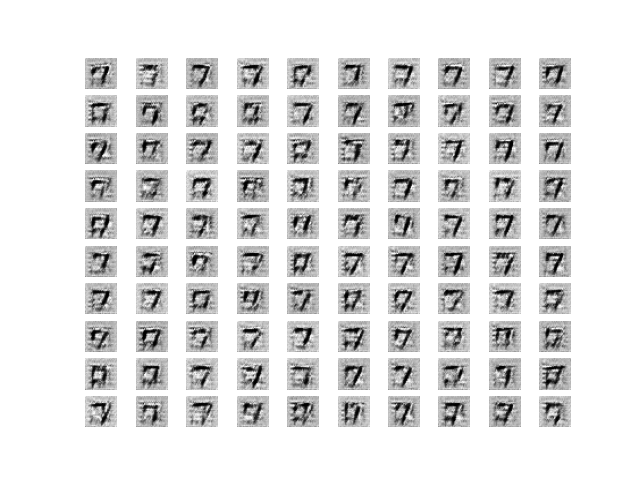